In this notebook I present how I generated the synthetic dataset and I present the data analysis algorithm (temporal event detection and spatial transient profile creator algorithm).

Synthetic data generation is a commonly used method in computational neuroscience. In general, 
the advantage of generating synthetic data is that it enables researchers to develop a robust 
algorithmic solution for solving a specific problem. Generating synthetic data is mostly a 
bottom-up process, whereas data analysis is a top-down process. Given the nature of synthetic 
data, even if the data analysis algorithm is not sufficient, there will always be opportunities to 
manipulate and deconstruct the data to better understand the potential limitations of our data 
analysis tools and then improve them.

On the original dataset - which I wish to replicate - we can see the Ca2+
fluorescent activity of mice hippocampal CA3 pyramidal neurons. Therefore, based on the idea of synthetic data 
generation introduced, the aim of this subsection is to show how I have modelled the Ca2+ 
fluorescence activity of CA3PNs. In the synthetic dataset, I generated the backpropagation signal 
of the soma (soma A), the local signal of the dendrite (dendrite A) and the contaminating signal 
of another soma (soma B).

In [1]:
#packages
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import scipy as sp

from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from sklearn.decomposition import NMF

## Spike trains

In [2]:
np.random.seed(45)

fr = 0.05 
fr_2 = fr/1.2 
dt = 1/30.0; 
Tmax = 90 
t = np.arange(0, Tmax, dt)
nBins = np.round(Tmax / dt).astype(int) 
nTrials = 1; 
myPoissonSpikeTrain_1 = np.random.rand(1,nBins) < fr*dt; 
spikes_a = myPoissonSpikeTrain_1.flatten()*1 

myPoissonSpikeTrain_2 = np.random.rand(1,nBins) < fr_2*dt; 
spikes_a_dend = myPoissonSpikeTrain_2.flatten()*1 

myPoissonSpikeTrain_3 = np.random.rand(1,nBins) < fr*dt; 
spikes_b = myPoissonSpikeTrain_3.flatten()*1 

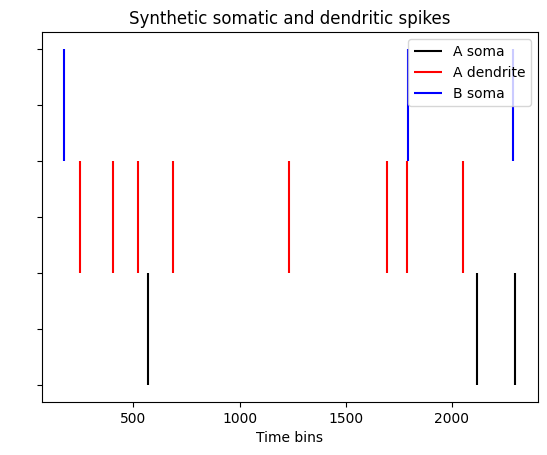

In [3]:
asspikes = plt.vlines(np.flatnonzero(spikes_a), 0, 1, 'k')
adspikes = plt.vlines(np.flatnonzero(spikes_a_dend), 1, 2, 'r')
bsspikes = plt.vlines(np.flatnonzero(spikes_b), 2, 3, 'b')

plt.title('Synthetic somatic and dendritic spikes')
plt.xlabel('Time bins')
plt.yticks(color='w')
plt.legend([asspikes,adspikes,bsspikes], ['A soma', 'A dendrite', 'B soma'])
plt.show()

Total number of spikes:

In [4]:
a_num_spikes = np.size(np.where(spikes_a))
a_dend_num_spikes = np.size(np.where(spikes_a_dend))
b_num_spikes = np.size(np.where(spikes_b))
insum = a_num_spikes + a_dend_num_spikes + b_num_spikes

In [5]:
#causal_conv_ker 
np.random.seed(85)
Lmax = 90
tt = np.arange(Lmax) / 30.0
tau_soma = 0.4
convker_soma = np.exp(-tt/tau_soma)
tau_dend = 0.3
convker_dend = np.exp(-tt/tau_dend)

dF_a_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a)), convker_soma, mode='valid') * 300
dF_a_dend = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a + spikes_a_dend)), convker_dend, mode='valid') * 300
dF_b_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_b)), convker_soma, mode='valid') * 300

In [6]:
len_dF = len(dF_a_soma)

Text(0.5, 1.0, 'Synthetic somatic signal - B soma')

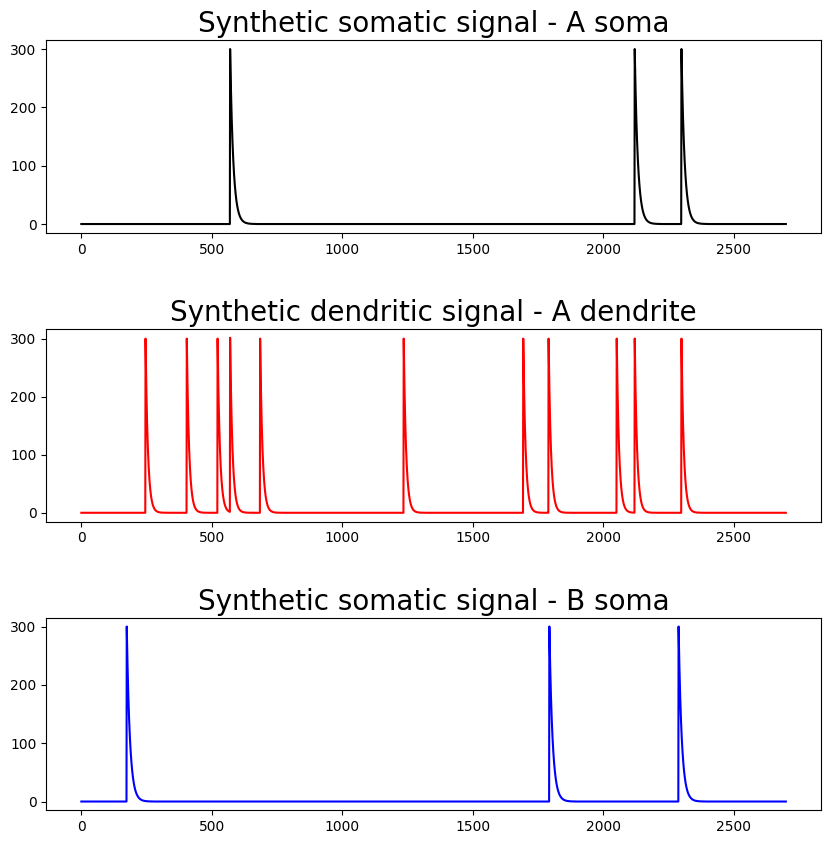

In [7]:
# Same previously plots with different layout
fig = plt.figure(figsize=(10, 10))

rows = 3
columns = 1

plt.subplots_adjust(hspace=0.5)

#1
fig.add_subplot(rows, columns, 1)
plt.plot(dF_a_soma, 'k')
plt.title('Synthetic somatic signal - A soma', fontsize = 20)

#2
fig.add_subplot(rows, columns, 2)
plt.plot(dF_a_dend, '-r')
plt.title('Synthetic dendritic signal - A dendrite', fontsize = 20)

#3
fig.add_subplot(rows, columns, 3)
plt.plot(dF_b_soma, '-b')
plt.title('Synthetic somatic signal - B soma', fontsize = 20)

## Generate images

In [8]:
x_1 = np.zeros(100)
x_1[11:51] = 1
y_1 = np.zeros(100)
y_1[10:50] = 1

x_2 = np.zeros(100)
x_2[51:81] = 1
y_2 = np.zeros(100)
y_2[20:36] = 1

x_3 = np.zeros(100)
x_3[51:91] = 1
y_3 = np.zeros(100)
y_3[21:61] = 1 

In [9]:
a_soma = np.outer(x_1, y_1)
dendrites = np.outer(x_2,y_2)
b_soma = np.outer(x_3,y_3)

masks = a_soma + 2*dendrites + 4*b_soma

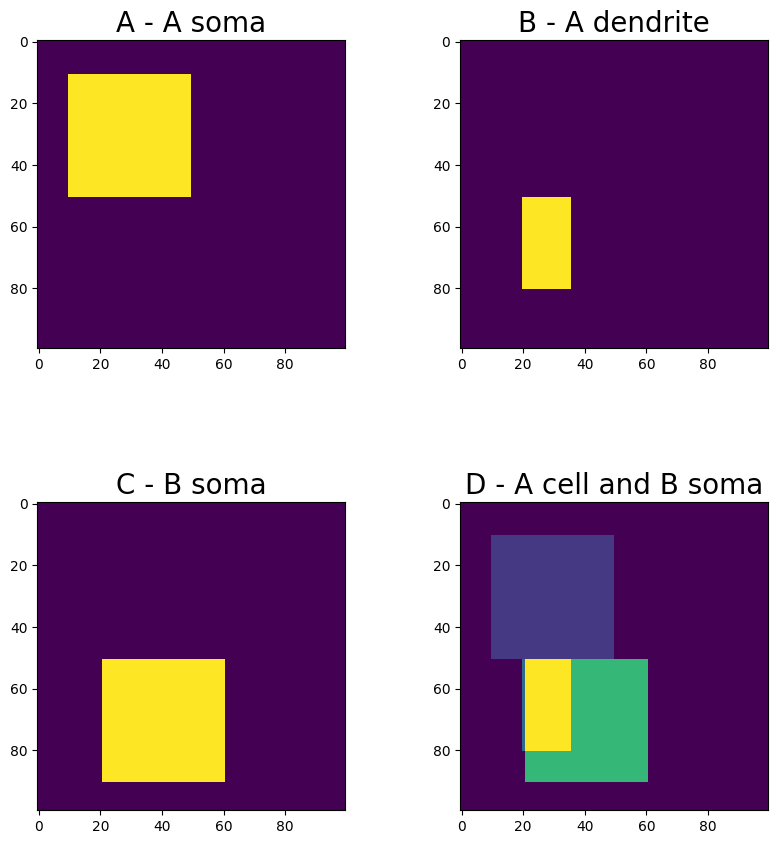

In [10]:
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2

plt.subplots_adjust(hspace=0.5)

#1
fig.add_subplot(rows, columns, 1)
plt.imshow(a_soma)
plt.title('A - A soma', fontsize = 20)

#2
fig.add_subplot(rows, columns, 2)
plt.imshow(dendrites)
plt.title('B - A dendrite', fontsize = 20)

#3
fig.add_subplot(rows, columns, 3)
plt.imshow(b_soma)
plt.title('C - B soma', fontsize = 20)

#4
fig.add_subplot(rows, columns, 4)
plt.imshow(masks)
plt.title('D - A cell and B soma', fontsize = 20)

masks_save = np.save('masks', masks)
asoma_save = np.save('asomabase', a_soma)
adendrite_save = np.save('adendritebase', dendrites)
bsoma_save = np.save('bsomabase', b_soma)

## Synthetic frames

In [11]:
a_soma_flat = a_soma.flatten()*1
dendrites_flat = dendrites.flatten()*1
b_soma_flat = b_soma.flatten()*1

a_soma_frames = np.outer(a_soma_flat, dF_a_soma)
dendrites_frames = np.outer(dendrites_flat, dF_a_dend)
b_soma_frames = np.outer(b_soma_flat, dF_b_soma)

(0.0, 2700.0)

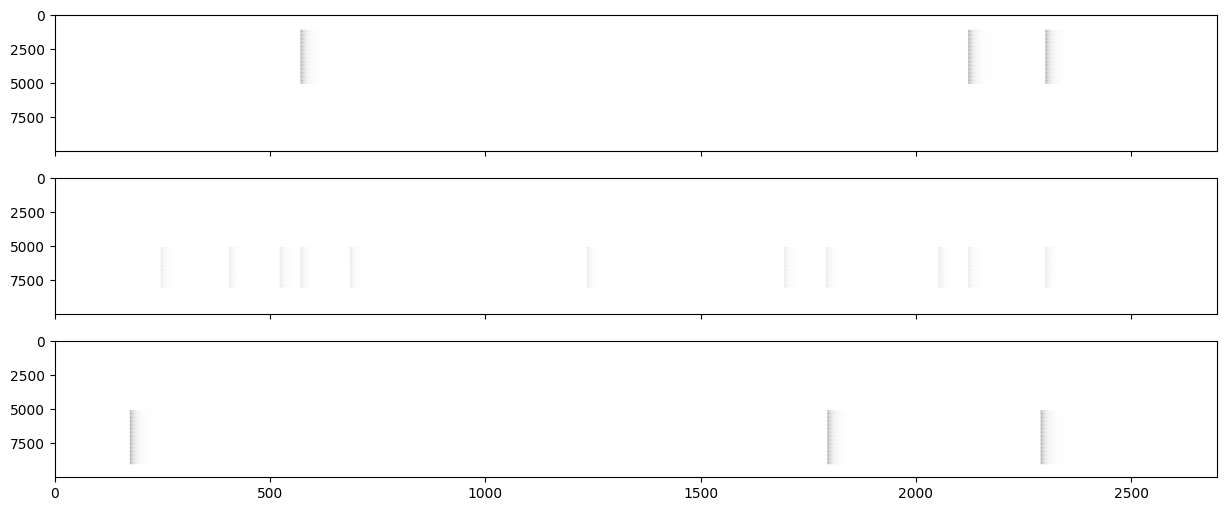

In [12]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 6))

#1
axs[0].imshow(a_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[0].set_xlim(0, len_dF)

#2
axs[1].imshow(dendrites_frames[:,:], cmap='Greys', aspect = 'auto')
axs[1].set_xlim(0, len_dF)

#3
axs[2].imshow(b_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[2].set_xlim(0, len_dF)

In [13]:
noise = np.random.normal(loc=400, scale=60, size = (10000, nBins))

In [14]:
dFdemo = a_soma_frames + dendrites_frames + b_soma_frames
dF0 = a_soma_frames + dendrites_frames + b_soma_frames + noise
dF = dF0.reshape((100,100, len_dF))

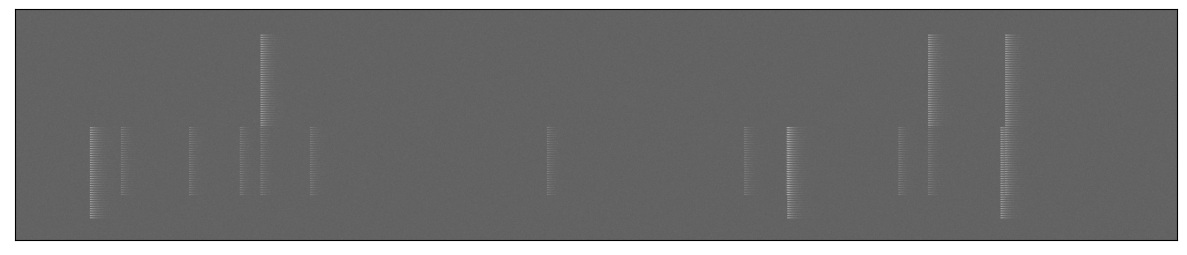

In [15]:
f, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 3))
axs.imshow((dF0[:,:]+1), cmap='Greys_r', aspect = 'auto')
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)

## Data analysis - creating spatial profiles

The data analysis algorithm has 5 major components:

1. Non-negative matrix factorization

This method essentially uses unsupervised machine learning to extract the fluorescence signal and source profile (see later) from the neuronal recording by decomposing data matrix (movie tensor after transposing to a matrix).

How does NMF decompose the given matrix? NMF can basically use the multiplicative update rule or the coordinate descent algorithm. The latter is preferable if speed is the goal, but in my case accuracy is a priority so I use the multiplicative update rule (hereafter MU).

MU's algorithm basically minimizes the divergence between two matrices, but this is a mathematical problem in itself for which NMF offers three solutions: the Frobenius norm, the Kullback-Leibler divergence and the Itakura-Saito divergence. The latter only works with values greater than zero, so I will only present the first two cases. In our case, the default setting is the KL divergence.

Another way of establishing divergence is KL-divergence, which establishes how much a probability distribution differs from another probability distribution, i.e. Dkl(W||H) = ∑ W(i)* log * (W(i)/H(i)), where the difference between W and H is the logarithm of the difference between W and H multiplied by the sum of W.

In the case of the MU, we are essentially minimizing the divergence of H and W, such that the algorithm generates two random matrices from the data as a base line (the random generation is manually adjusted as a function of the scikit learn NMF). Importantly, the data cannot be negative, since the NMF only works with positive values. Once the matrix W and H are obtained, the algorithm updates (iteratively) the previous values of W and H by multiplying the original matrix (X) by W for H, and then dividing W * H (matrix approximating X) by the product of W. This is continuously iterated with the value of W obtained in the previous iteration. For W, this is done in the reverse fraction, so the original matrix (X) is multiplied by H and then divided by the product of W * H and H. The algorithm repeats the operation until one of the above divergence indicators shows that the matrix W and H are no longer convergent, or until the number of iterations specified in the manifold setting is reached. For regularizing the NMF we use L1 - Lasso and L2 - Ridge regression.

2. dF/F signal

Since each signal have different baseline, we need to align every dF signal to the same baseline (Neugornet, 2021). To achieve this, I subtracted the F0 (median of F) from it and divided it by F0 (Neugornet, 2021). We mark the result of this operation as dF/F.

3. Gauss smoothing:

Before developing an event detection algorithm, first, I needed to apply a signal smoothing
method on the dF/F signals. Signal smoothing is essential for event detection. Firstly, because it
increases the signal-to-noise ratio (Brett, n.d.). Secondly, raw signals generally contain noise
fluctuation in the high frequencies and detecting the small high frequency noise peaks can be
misleading when we aim to detect real events in the signal (Brett, n.d.). Although, by gently
smoothing the signal we essentially apply a high pass filter on the signal via convolving a
particular kernel on the signal (Brett, n.d.). This returns a signal that contains low, mid frequency
and a smaller range of high frequencies. Therefore, it is more suitable to detect neuronal events
on it.

4. Temporal event detection

For detecting neural events, I defined a function that detects any event above a specific threshold
(θhigh) of the signal amplitude in time (Appendix 1.2.). After detecting the event the algorithm
assigns a decay period to the signal, which is essentially the remaining part of the signal array
until it reaches a secondary threshold (θlow) (Heitler, 2023). Obviously, theta lower is always set
below θhigh (Heitler, 2023). The function uses a simple way to detect specific events: When the
signal reaches the threshold, the function tests whether the N-1th element is lower than the event
threshold and the Nth element is higher, so it returns 1 (Heitler, 2023). If this is not the case, the
signal must not be detected. In the latter case the signal did not go above θhigh, however it did not
go above θlow as well, which means it is still a decay period, so the function must return 0
(Heitler, 2023). For event detection I used the same thresholds on every signal for simplicity
(θhigh = 0.25; θlow = 0.1).

5. Creating spatial transient profiles

Temporal events are also observable in space. If we measure correlation between the spatial profile of a transient event with the mean image (source profile) of the activity of a neural compartment we can determine, whether a specific transient is true transient or a false transient (contamination of another cell's activity) based on the correlation coefficient - true transients shows high correlation (r > 0.7). If a specific event is true event and the dendritic dF/F signal is not identifiable at the dF/F signal of the soma we consider it as an isolated or independent dendritic event.

Transient profiles were calculated by using the weighted sum of ith video frames, where I weight them by the ith element of the transient time course then summing it. Then I normalized by the total magnitude of the transient event (Gauthier et al., 2022). 

The below implemented function (create_spatial_transient_profiles) does all these steps in one function. The function returns a .pdf file which contains all the spatial transient profiles of a dendritic fluorescent signal.

In [16]:
# Expanding the ROI-s with some pixels:

d = 5

ROI_Asoma = dF[11-d:51+ d, 10-d:50+d, :]

ROI_dendrite = dF[51-d:81+ d, 20-d:36+d, :] #45:85, 15:40

ROI_Bsoma = dF[51-d:91+d, 21-d:61+d, :]

In [19]:
dF_mean_img = np.mean(dF, axis =2)

Function arguments:

create_spatial_transient_profiles(mean image, observed soma movie, observed dendrite moive, unobserved soma movie,
                                  observed soma original signal,
                                  observed dendrite original signal, unobserved soma original signal, 
                                  NMF divergnce = 'kullback-leibler', NMF iteration = 5000,
                                  alpha_W = 0.0011, alpha_H = 0.0017, 
                                  l1 ratio (0.5 means 0.5 for both L1 and L2) = 0.5,
                                  Gauss smoothing sigma = 0.5, upper event detection threshold = 1.65,
                                  lower event detection threshold = 1.6,
                                  how many index to use before and after the transient = 50,
                                  which recording sequence (for time scale) = 1,
                                  .pdf page title = '{0}. dendritic transient', .pdf filename= ''):

In [20]:
def create_spatial_transient_profiles(mean_img_total_view, Asoma_ROI_movie_data, dendrite_ROI_movie_data, Bsoma_ROI_movie_data,
                                      Asoma_original_sig, dendrite_original_sig, Bsoma_original_sig, 
                                      beta_loss = 'kullback-leibler', max_iter = 5000,
                                      alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5,
                                      sigma = 0.5, theta_upper = 1.65, theta_lower = 1.6,
                                      offset = 50, w_seq = 4, title = '{0}. dendritic transient', filename= ''):
    
    # Extracting source profiles and fluorescent signals by non-negative matrix factorization:
    # - Soma NMF:
    Asoma_x, Asoma_y, Asoma_z = np.shape(Asoma_ROI_movie_data)
    Asoma_matrix = Asoma_ROI_movie_data.reshape(Asoma_x*Asoma_y,Asoma_z)

    
    Asoma_model = NMF(n_components = 1, init='random', random_state = 0, solver = 'mu', beta_loss = 'kullback-leibler', max_iter = 5000, alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5)# multiplicative addtion and Kullback-Leibler divergence
    Asoma_W = Asoma_model.fit_transform(Asoma_matrix)
    Asoma_H = Asoma_model.components_
    
    Asoma_fluorescent_signal = Asoma_H.reshape(1*Asoma_z)
    Asoma_fluorescent_signal = (Asoma_fluorescent_signal - np.median(Asoma_fluorescent_signal)) / np.median(Asoma_fluorescent_signal)
    
    # - Dendrite NMF:
    dendrite_x, dendrite_y, dendrite_z = np.shape(dendrite_ROI_movie_data)
    dendrite_matrix = dendrite_ROI_movie_data.reshape(dendrite_x*dendrite_y,dendrite_z)

    
    dendrite_model = NMF(n_components=1, init='random', random_state = 0, solver = 'mu', beta_loss = 'kullback-leibler', max_iter = 5000, alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5)# multiplicative addtion and Kullback-Leibler divergence
    dendrite_W = dendrite_model.fit_transform(dendrite_matrix)
    dendrite_H = dendrite_model.components_
    
    source_profile = dendrite_W.reshape(dendrite_x,dendrite_y)
    dendrite_fluorescent_signal = dendrite_H.reshape(1*dendrite_z)
    dendrite_fluorescent_signal = (dendrite_fluorescent_signal - np.median(dendrite_fluorescent_signal)) / np.median(dendrite_fluorescent_signal)
    
    # - B soma NMF:
    Bsoma_x, Bsoma_y, Bsoma_z = np.shape(Bsoma_ROI_movie_data)
    Bsoma_matrix = Bsoma_ROI_movie_data.reshape(Bsoma_x*Bsoma_y,Bsoma_z)

    
    Bsoma_model = NMF(n_components=1, init='random', random_state=0, solver='mu', beta_loss='kullback-leibler', max_iter=5000, alpha_W=0.0011, alpha_H=0.0017, l1_ratio=0.5)# multiplicative addtion and Kullback-Leibler divergence
    Bsoma_W = Bsoma_model.fit_transform(Bsoma_matrix)
    Bsoma_H = Bsoma_model.components_
    
    Bsoma_fluorescent_signal = Bsoma_H.reshape(1*Bsoma_z)
    Bsoma_fluorescent_signal = (Bsoma_fluorescent_signal - np.median(Bsoma_fluorescent_signal)) / np.median(Bsoma_fluorescent_signal)
    
    # signal arrays must be padded before implementing convolution to preserve the index of the original signal transient events
    def preprocess_for_conv(signal_for_gauss, kernel_length):
        N = len(signal_for_gauss)
        if (kernel_length % 2) == 0:
            return ('Kernel length is even.')
        K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
        new_arr = np.zeros(N + 2*K) 
        signal_start = signal_for_gauss[0]
        signal_end = signal_for_gauss[-1]
        new_arr[0:K] =  signal_start
        new_arr[-K:] = signal_end
        new_arr[K:(N+K)] = signal_for_gauss
        return new_arr
    
    Asoma_fluorescent_signal = preprocess_for_conv(Asoma_fluorescent_signal, 15)
    dendrite_fluorescent_signal = preprocess_for_conv(dendrite_fluorescent_signal, 15)
    Bsoma_fluorescent_signal = preprocess_for_conv(Bsoma_fluorescent_signal, 15)
    
    # Signal smoothing
    x = np.arange(-7,8,1)
    sigma = 0.5
    normal = 1 / (2.0 * np.pi * sigma**2)
    gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
    gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
    
    Asoma_fluorescent_signal = np.convolve(Asoma_fluorescent_signal, gauss_kernel,mode = 'valid')
    dendrite_fluorescent_signal = np.convolve(dendrite_fluorescent_signal, gauss_kernel, mode = 'valid')
    Bsoma_fluorescent_signal = np.convolve(Bsoma_fluorescent_signal, gauss_kernel,mode = 'valid')
    
    # Event detection:
    N = len(dendrite_fluorescent_signal)
    signal = dendrite_fluorescent_signal
    event = np.zeros(N)
    transient = np.zeros(N)
    start_end = []
    
    refr = 0
    start_end_i = np.zeros(2)
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
            start_end_i[0] = i
        if ((signal[i]<theta_lower) and (signal[i-1]>theta_lower) and (refr == 1)):
            refr = 0
            start_end_i[1] = i
            start_end.append(start_end_i)
            start_end_i = np.zeros(2)
        if (refr == 1):
            transient[i] = 1
    if ((start_end_i[0] > 0) & (start_end_i[1] == 0)):
        start_end_i[1] = N
        start_end.append(start_end_i)
        
    
    start = np.array(start_end)[:,0].astype(int)
    end = np.array(start_end)[:,1].astype(int)
    
    
    # Transient profiles:
    transient_profs = []
    l=len(start)
    for j in range(l):
        
        transient_signal = signal
        movie_tensor = dendrite_ROI_movie_data
        index = np.arange(start[j]-5, end[j]+5)
        index_len = np.arange(0,len(index),1)
        transient = transient_signal[index]
        movie_tensor = movie_tensor[:,:,index]
        Y = transient[np.newaxis, np.newaxis, :] * movie_tensor #weighted_frames
        transient_pic = np.sum(Y[:,:,index_len],axis=2)
        normalized_trans_pic = transient_pic/sum(transient**2)
        transient_prof = normalized_trans_pic
        transient_profs.append(transient_prof)
    
    Asoma_signal = Asoma_fluorescent_signal
    dendrite_signal = dendrite_fluorescent_signal
    Bsoma_signal = Bsoma_fluorescent_signal
    dendrite_source_profile = source_profile
    index_start = start
    index_stop = end
    transient_profiles = transient_profs
    
    l = len(np.array(index_start))
    for k in range(l):
        
        transient_profile = transient_profiles[k]
        cor = np.round(sp.stats.pearsonr(transient_profile.flatten(), dendrite_source_profile.flatten())[0], 3)
        
        interval_min = offset 
        interval_max = interval_min + (index_stop[k]-index_start[k]) + 1
        
        # time-scale parameters
        len_signal = len(dendrite_signal)
        len_signal = len_signal*w_seq
        current = 112*w_seq
        time_len_s = round(current/len_signal,2)
        start_point = index_start[k]-offset
        start_point = start_point+len_signal
        end_point = index_stop[k]+offset
        end_point = end_point+len_signal
        time_interval = round((end_point-start_point)/5)
        lbls = [i*time_len_s for i in list(range(start_point, end_point, time_interval))] #start_point
        lbls = [round(num, 1) for num in lbls]
        tcks = list(range(0, end_point-start_point, time_interval))
        
        fig = plt.figure(k)
        fig.set_figheight(15)
        fig.set_figwidth(20)
        
        plt.subplots_adjust(hspace=0.5)
        
        rows = 3
        columns = 3
        
        fig.add_subplot(rows, columns, 1)
        plt.imshow(mean_img_total_view)
        plt.title('Total view of the \n synthetic movie data', fontsize = 20)
        plt.axis('off')
        
        fig.add_subplot(rows, columns, 2)
        plt.imshow(dendrite_source_profile)
        plt.title('Source profile \n', fontsize = 20)
        plt.axis('off')
        
        ax = fig.add_subplot(rows, columns, 3)
        ax.imshow(transient_profile)
        
        plt.title('Transient profile \n r = {0}'.format(cor), fontsize = 20)
        plt.xticks(color = 'w')
        plt.yticks(color = 'w')

        color = "red" if cor > 0.7 else "white"
        for x in ["top","left","right","bottom"]:
            ax.spines[x].set_color(color)
            ax.spines[x].set_linewidth(5)
            
        # DF/F signals    
        fig.add_subplot(rows, columns, 4)
        plt.plot(Asoma_signal[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('A soma \n dF/F signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 1)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        fig.add_subplot(rows, columns, 5)
        plt.plot(dendrite_signal[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('A dendrite \n dF/F signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 1)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        fig.add_subplot(rows, columns, 6)
        plt.plot(Bsoma_signal[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('B soma \n dF/F signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 1)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        # Original signals
        fig.add_subplot(rows, columns, 7)
        plt.plot(Asoma_original_sig[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('A soma \n original signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 350)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        fig.add_subplot(rows, columns, 8)
        plt.plot(dendrite_original_sig[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('A dendrite \n original signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 350)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        fig.add_subplot(rows, columns, 9)
        plt.plot(Bsoma_original_sig[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('B soma \n original signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.5, 350)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color='moccasin', alpha=0.7)
        
        title_num = 1
        title_num = title_num + k
        
        fig.suptitle(title.format(title_num), fontsize=20, weight = 'bold')
        
        pdf_pages = len(index_stop)
        
        with PdfPages(filename) as pdf:
            for fig in range(pdf_pages):
                plt.figure(fig)
                pdf.savefig(bbox_inches="tight")             

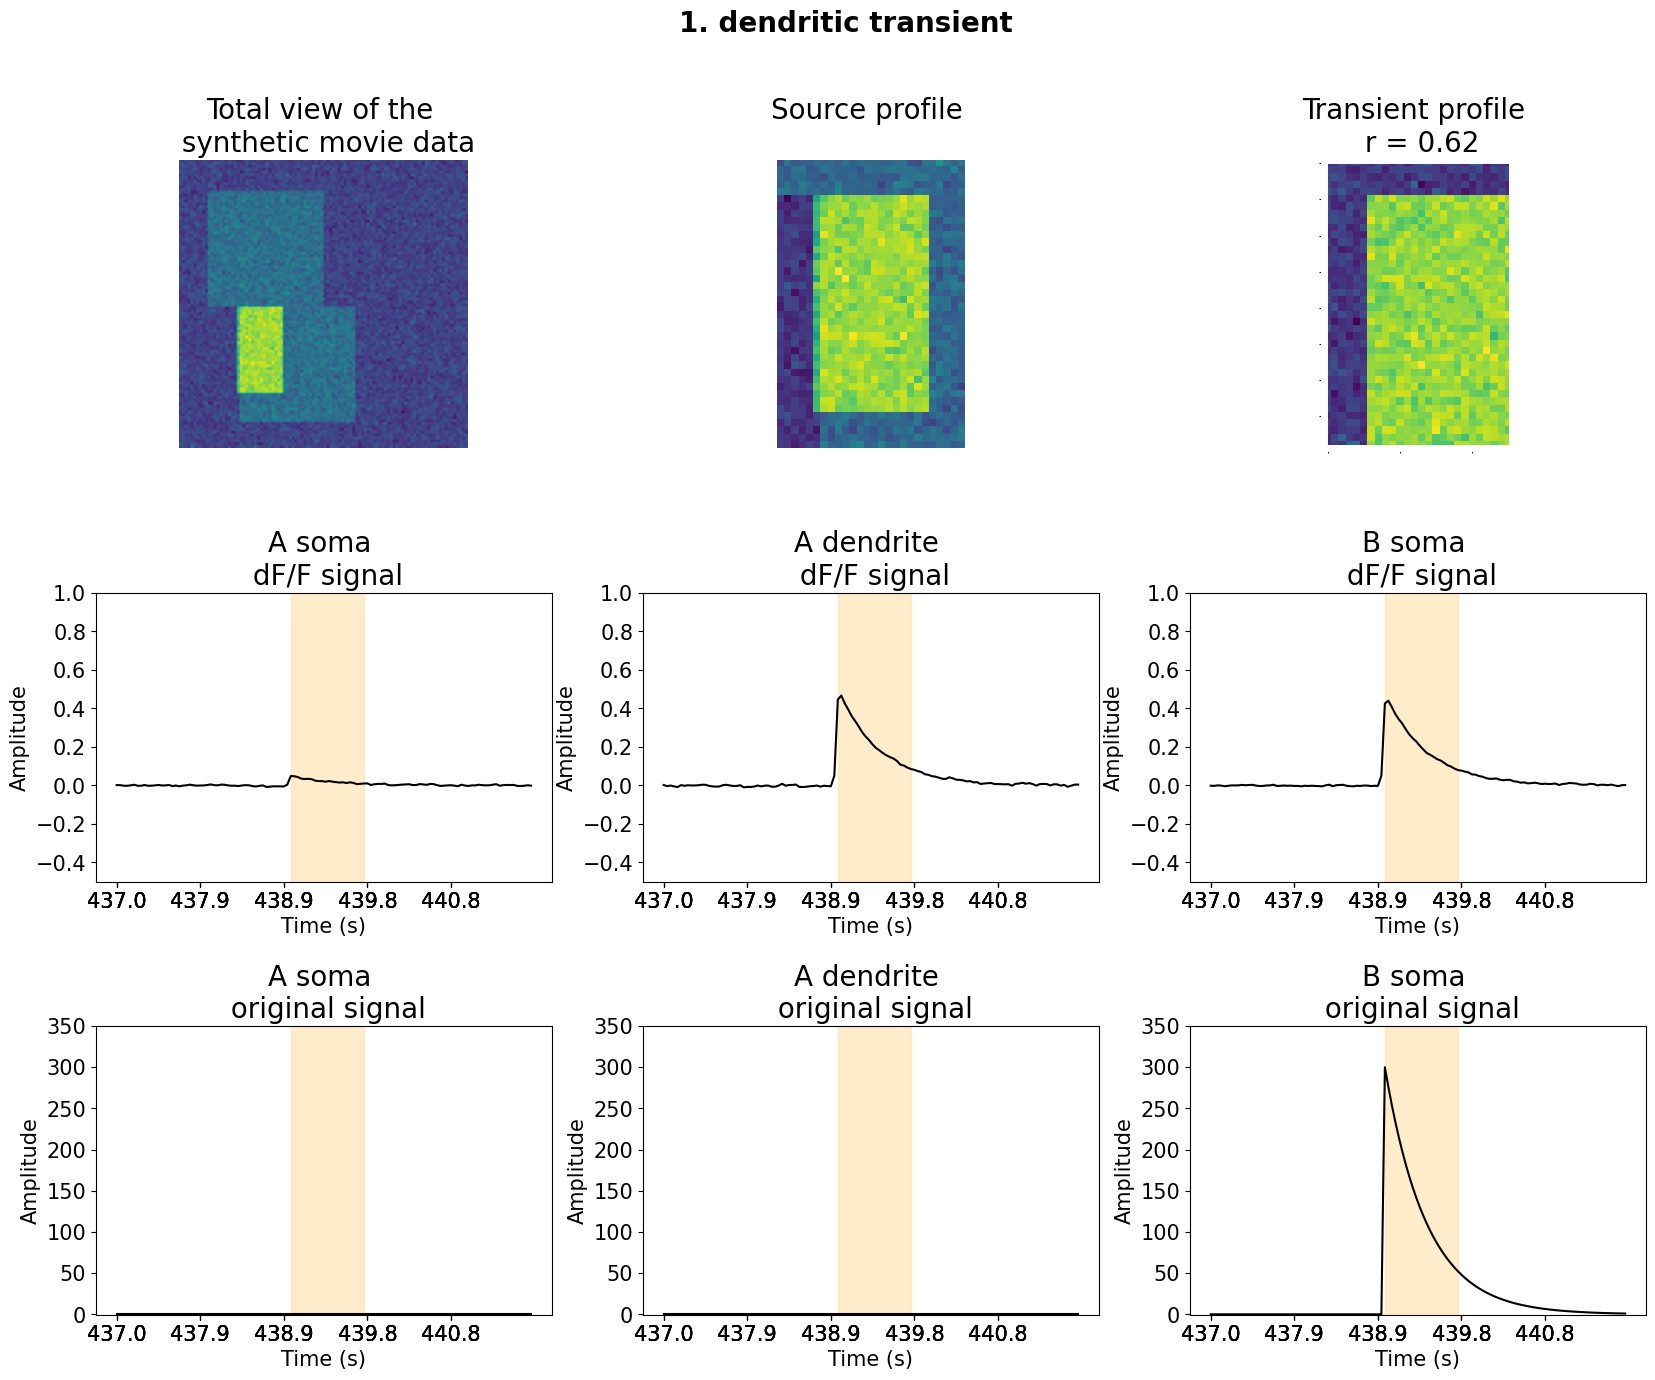

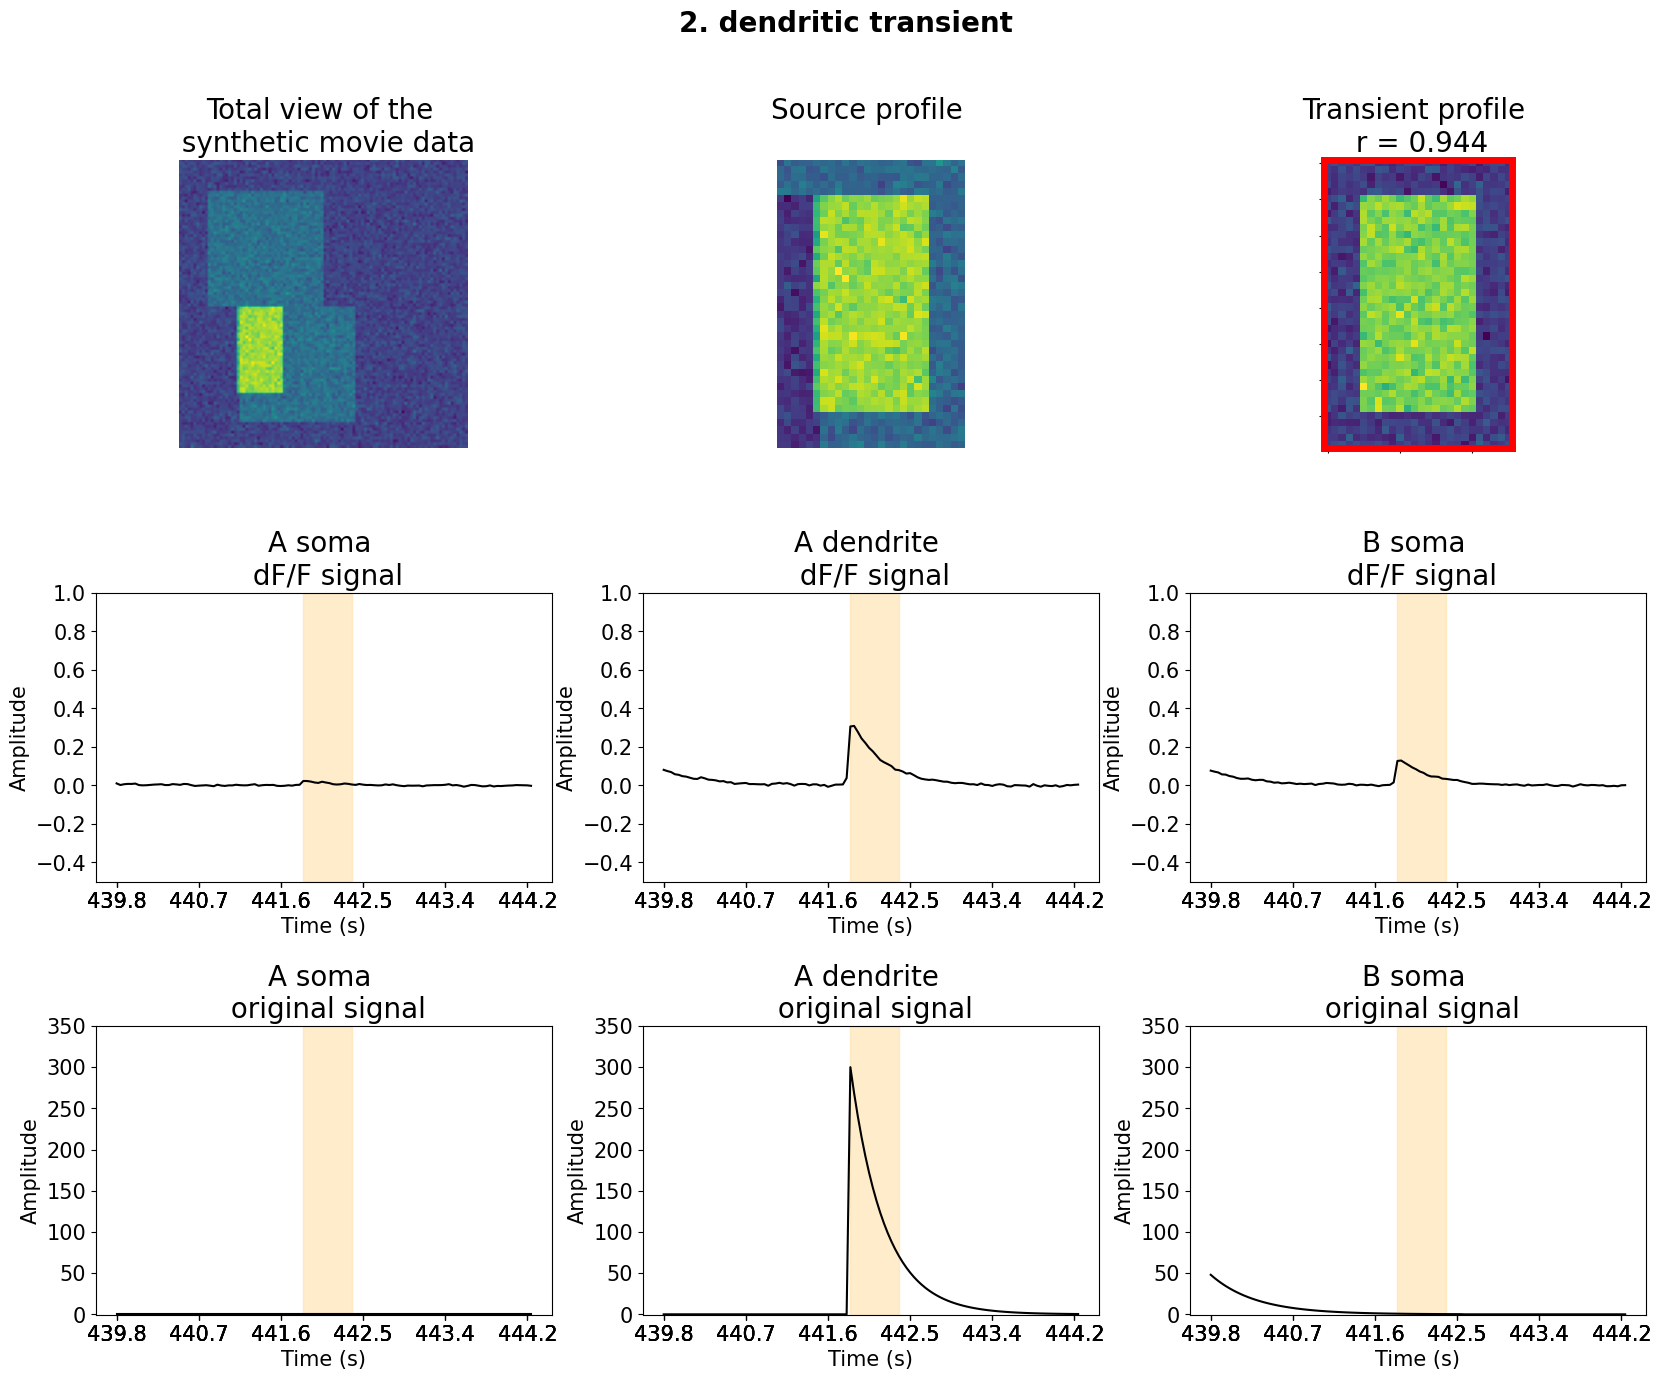

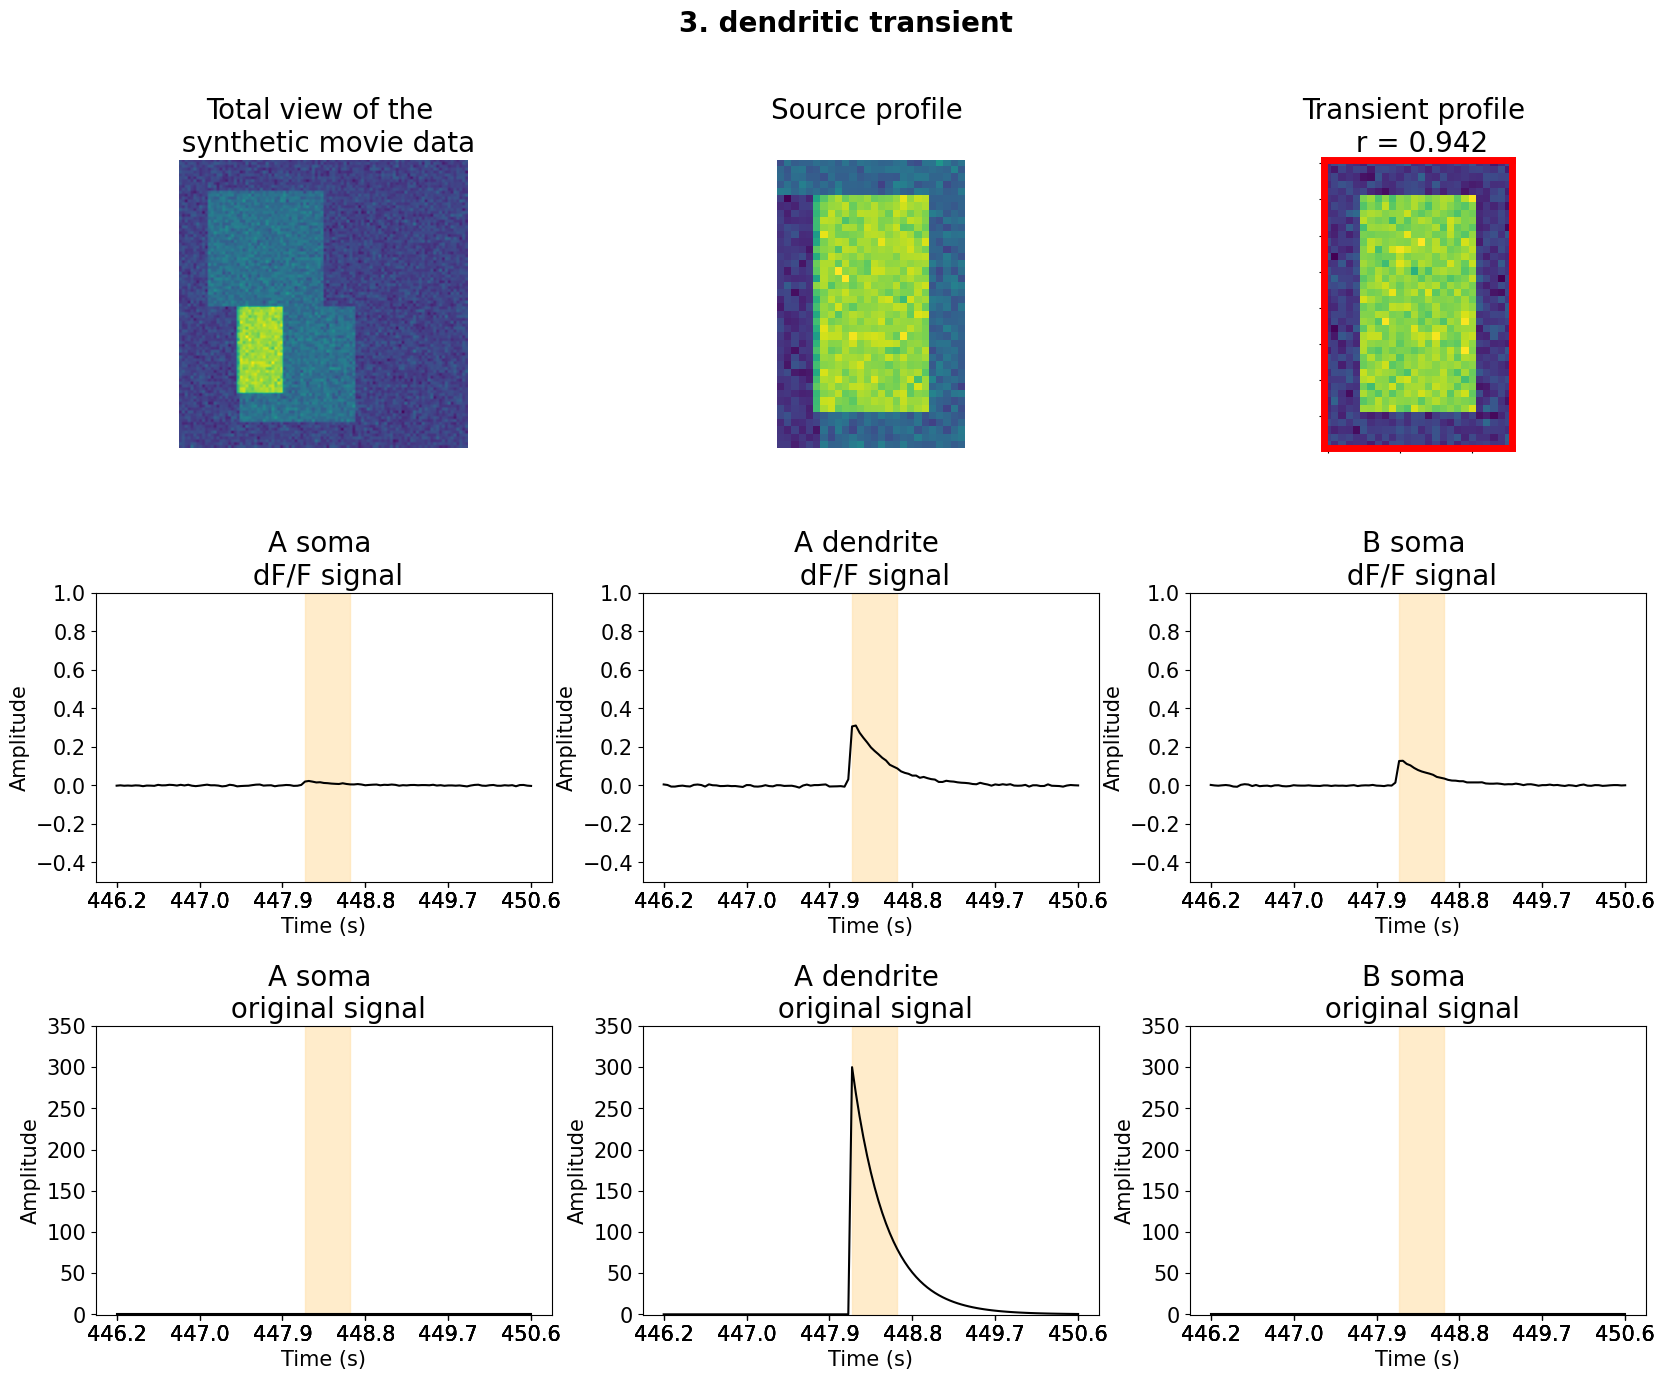

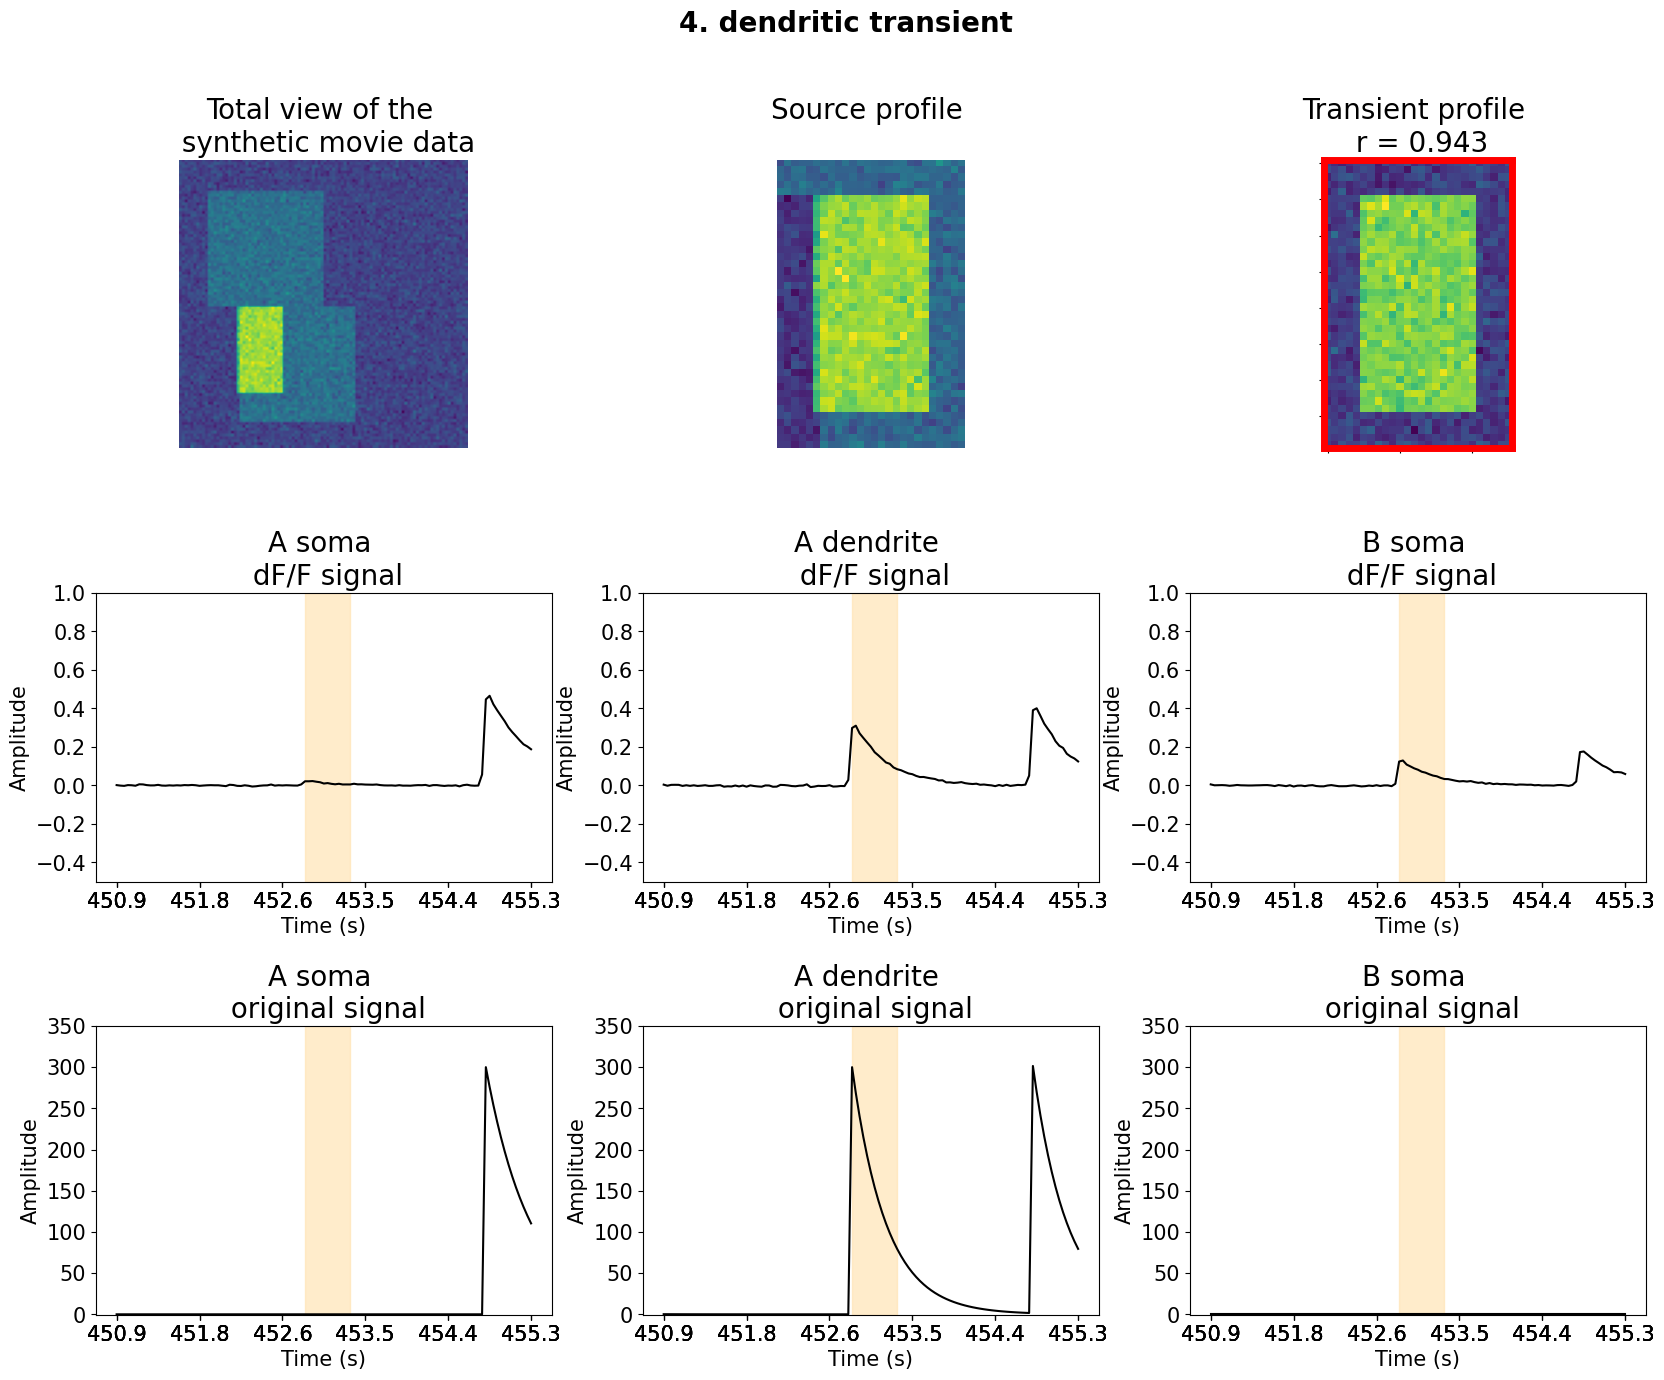

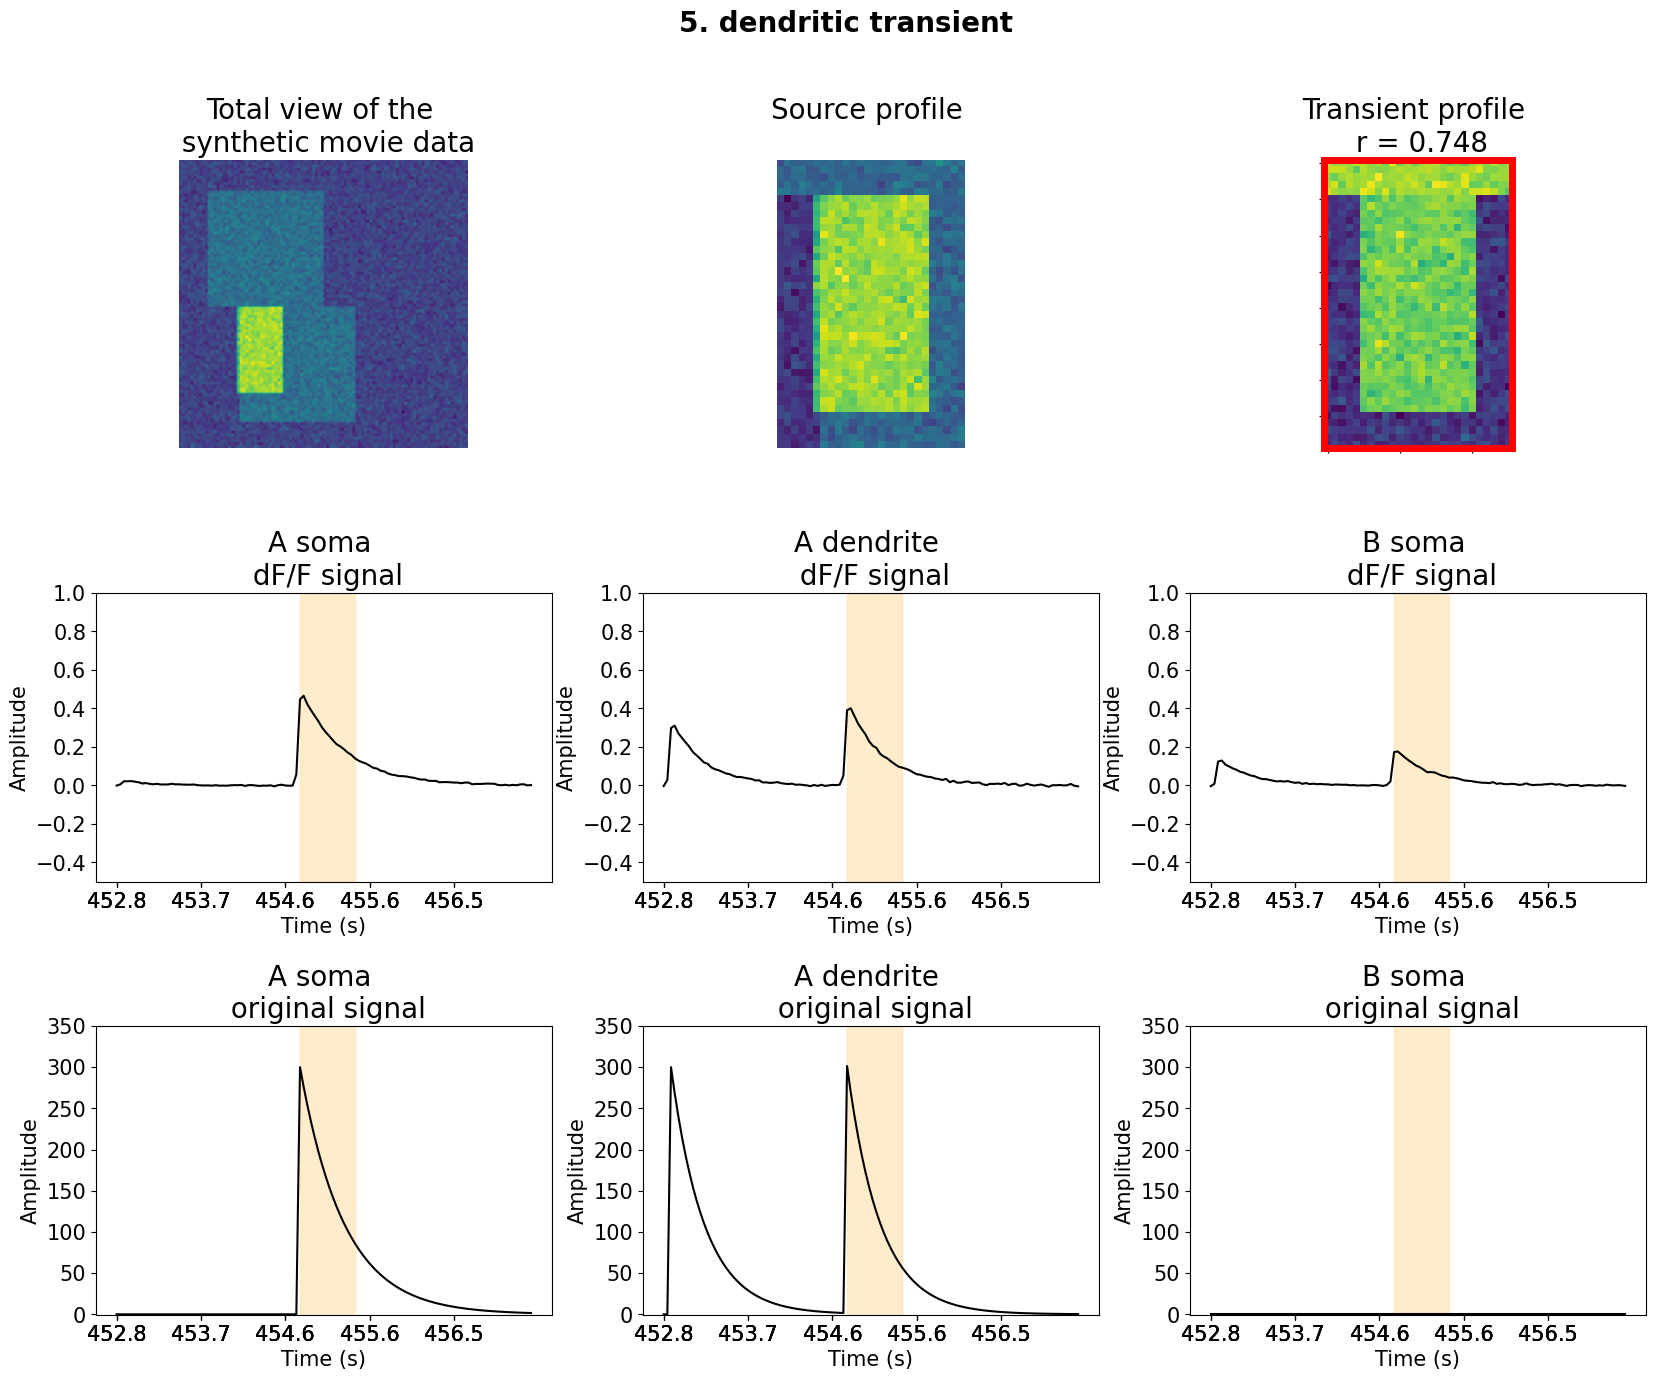

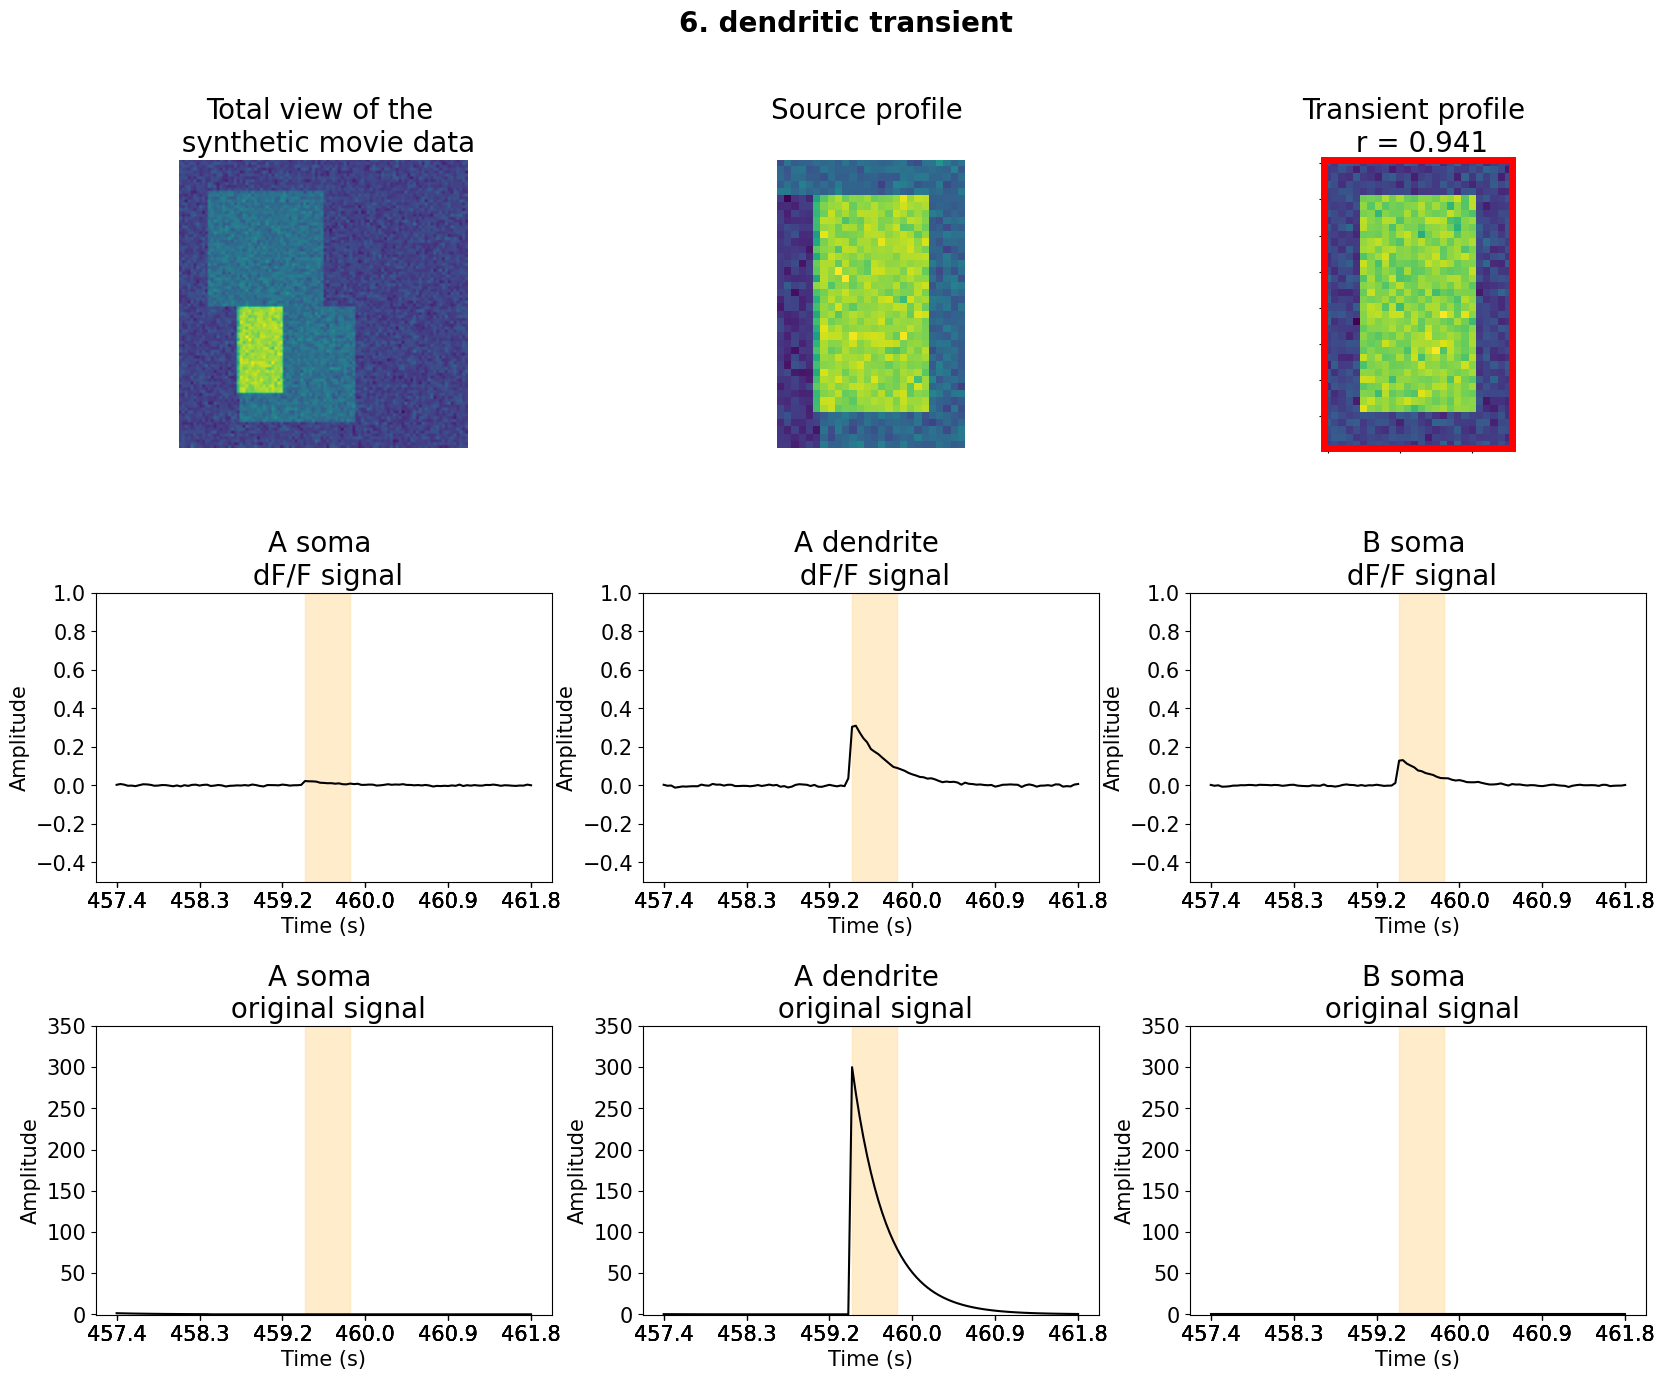

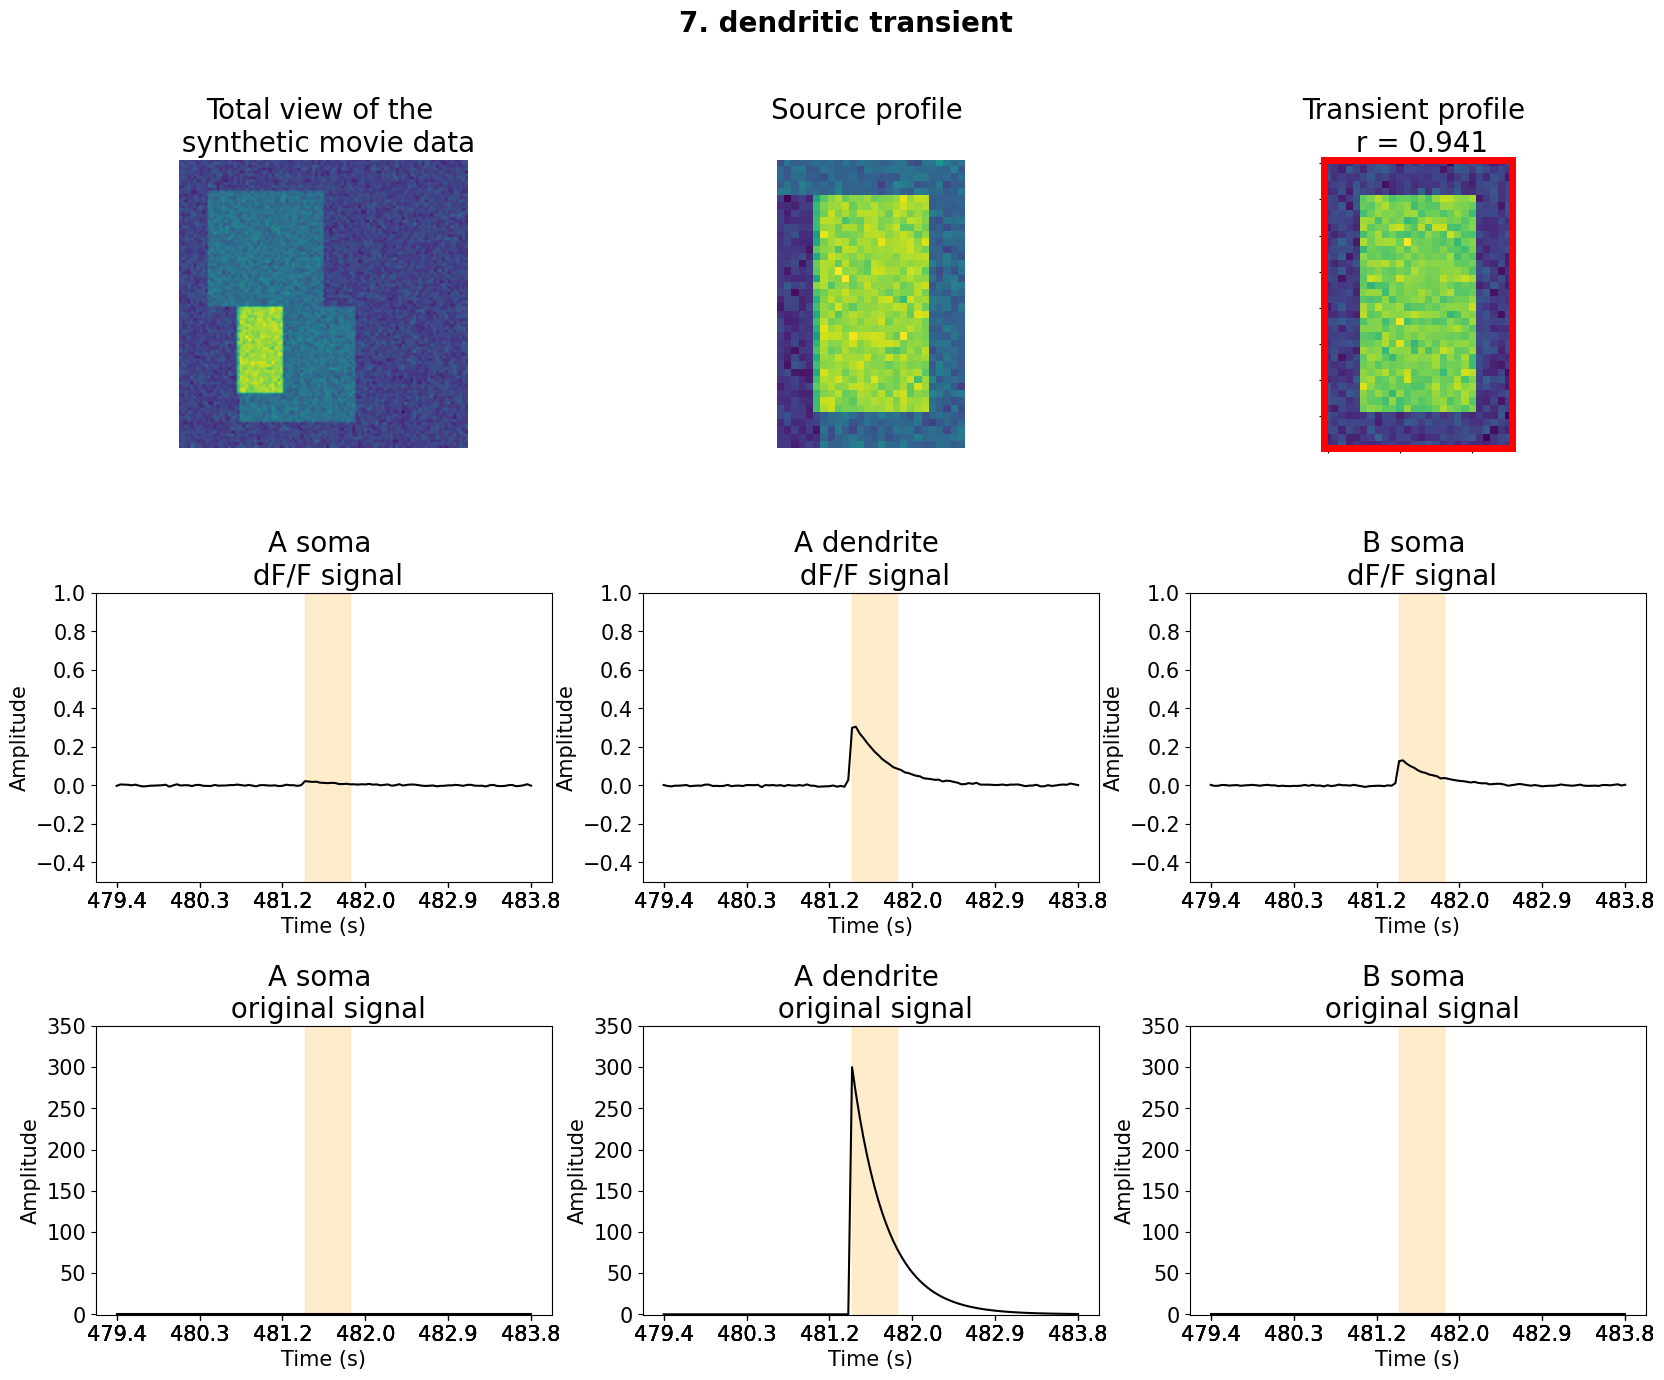

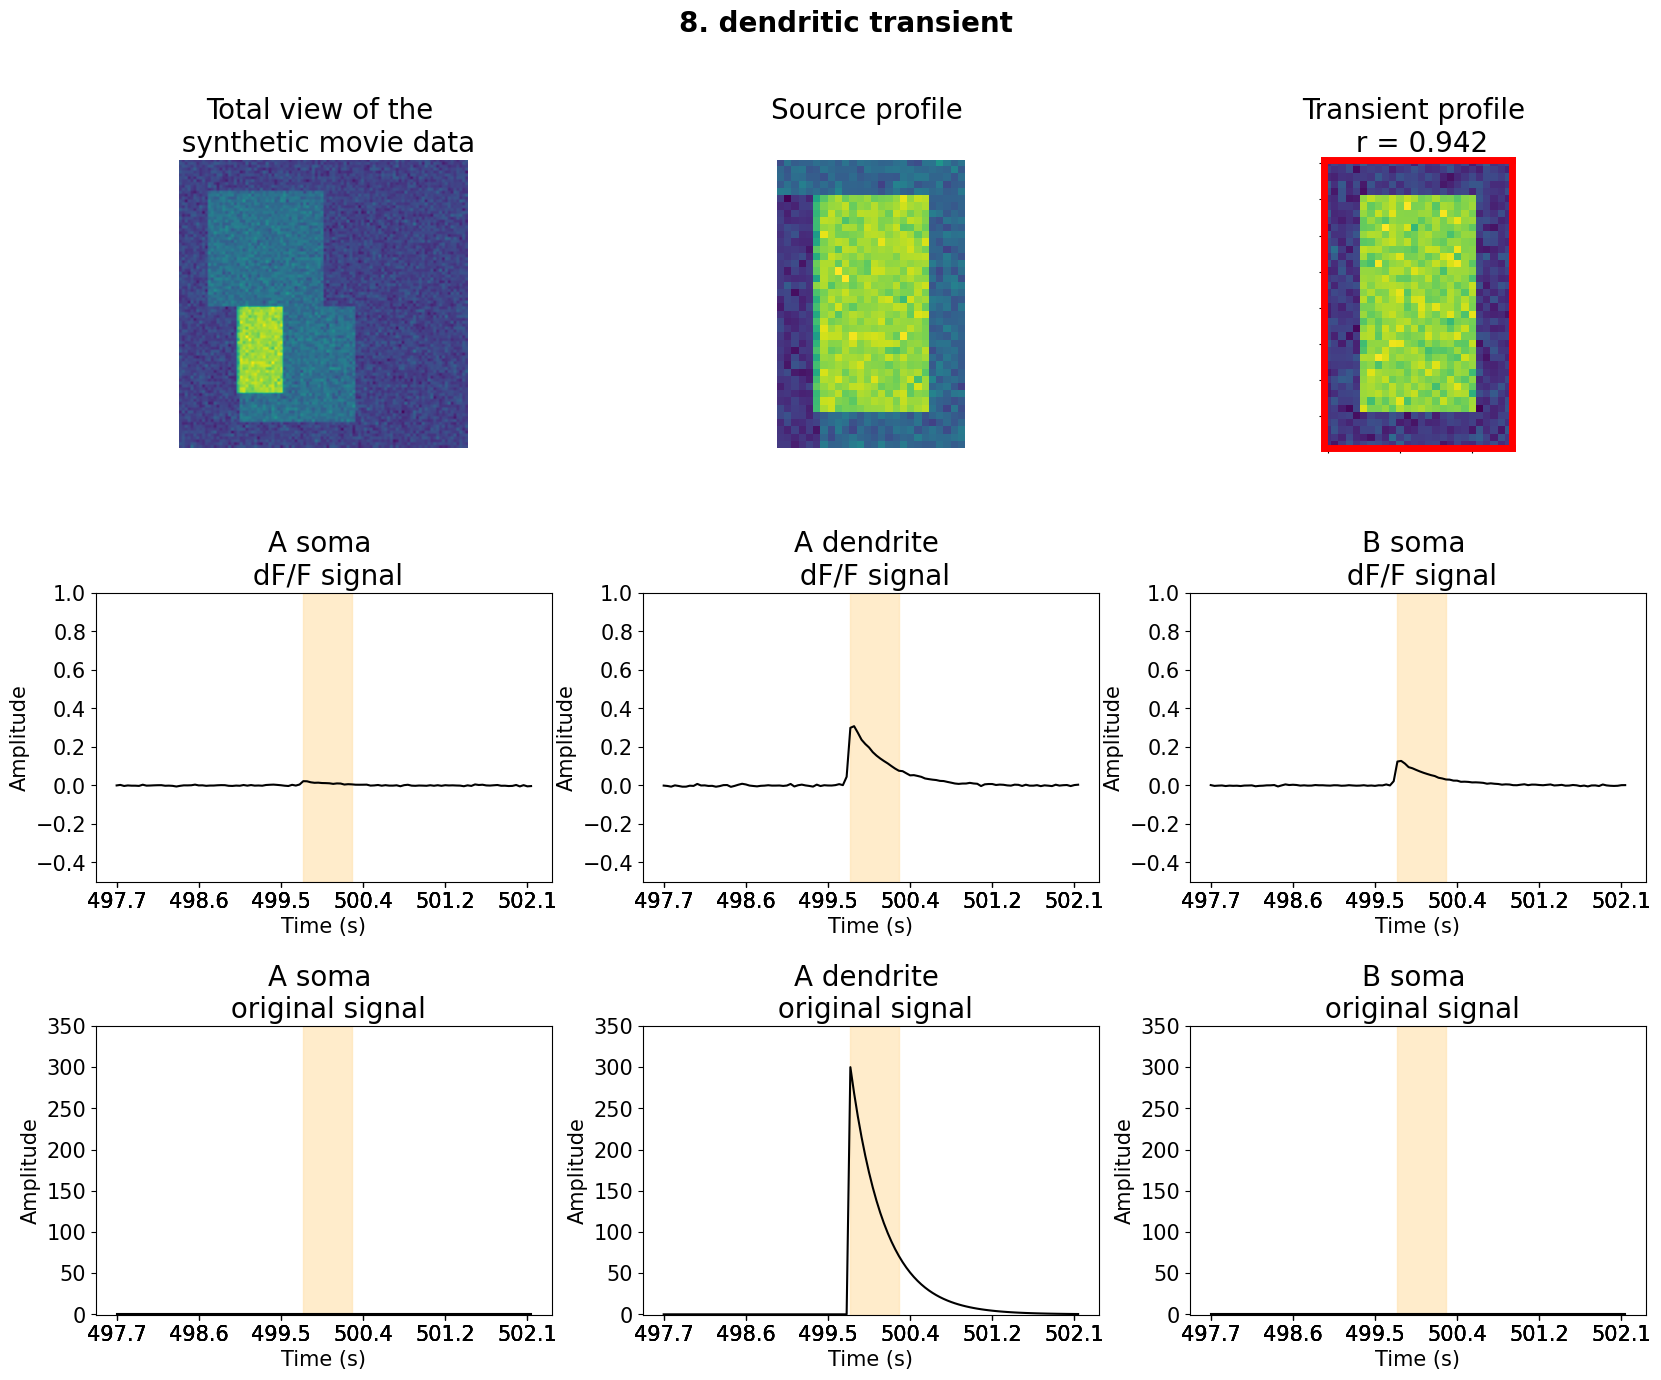

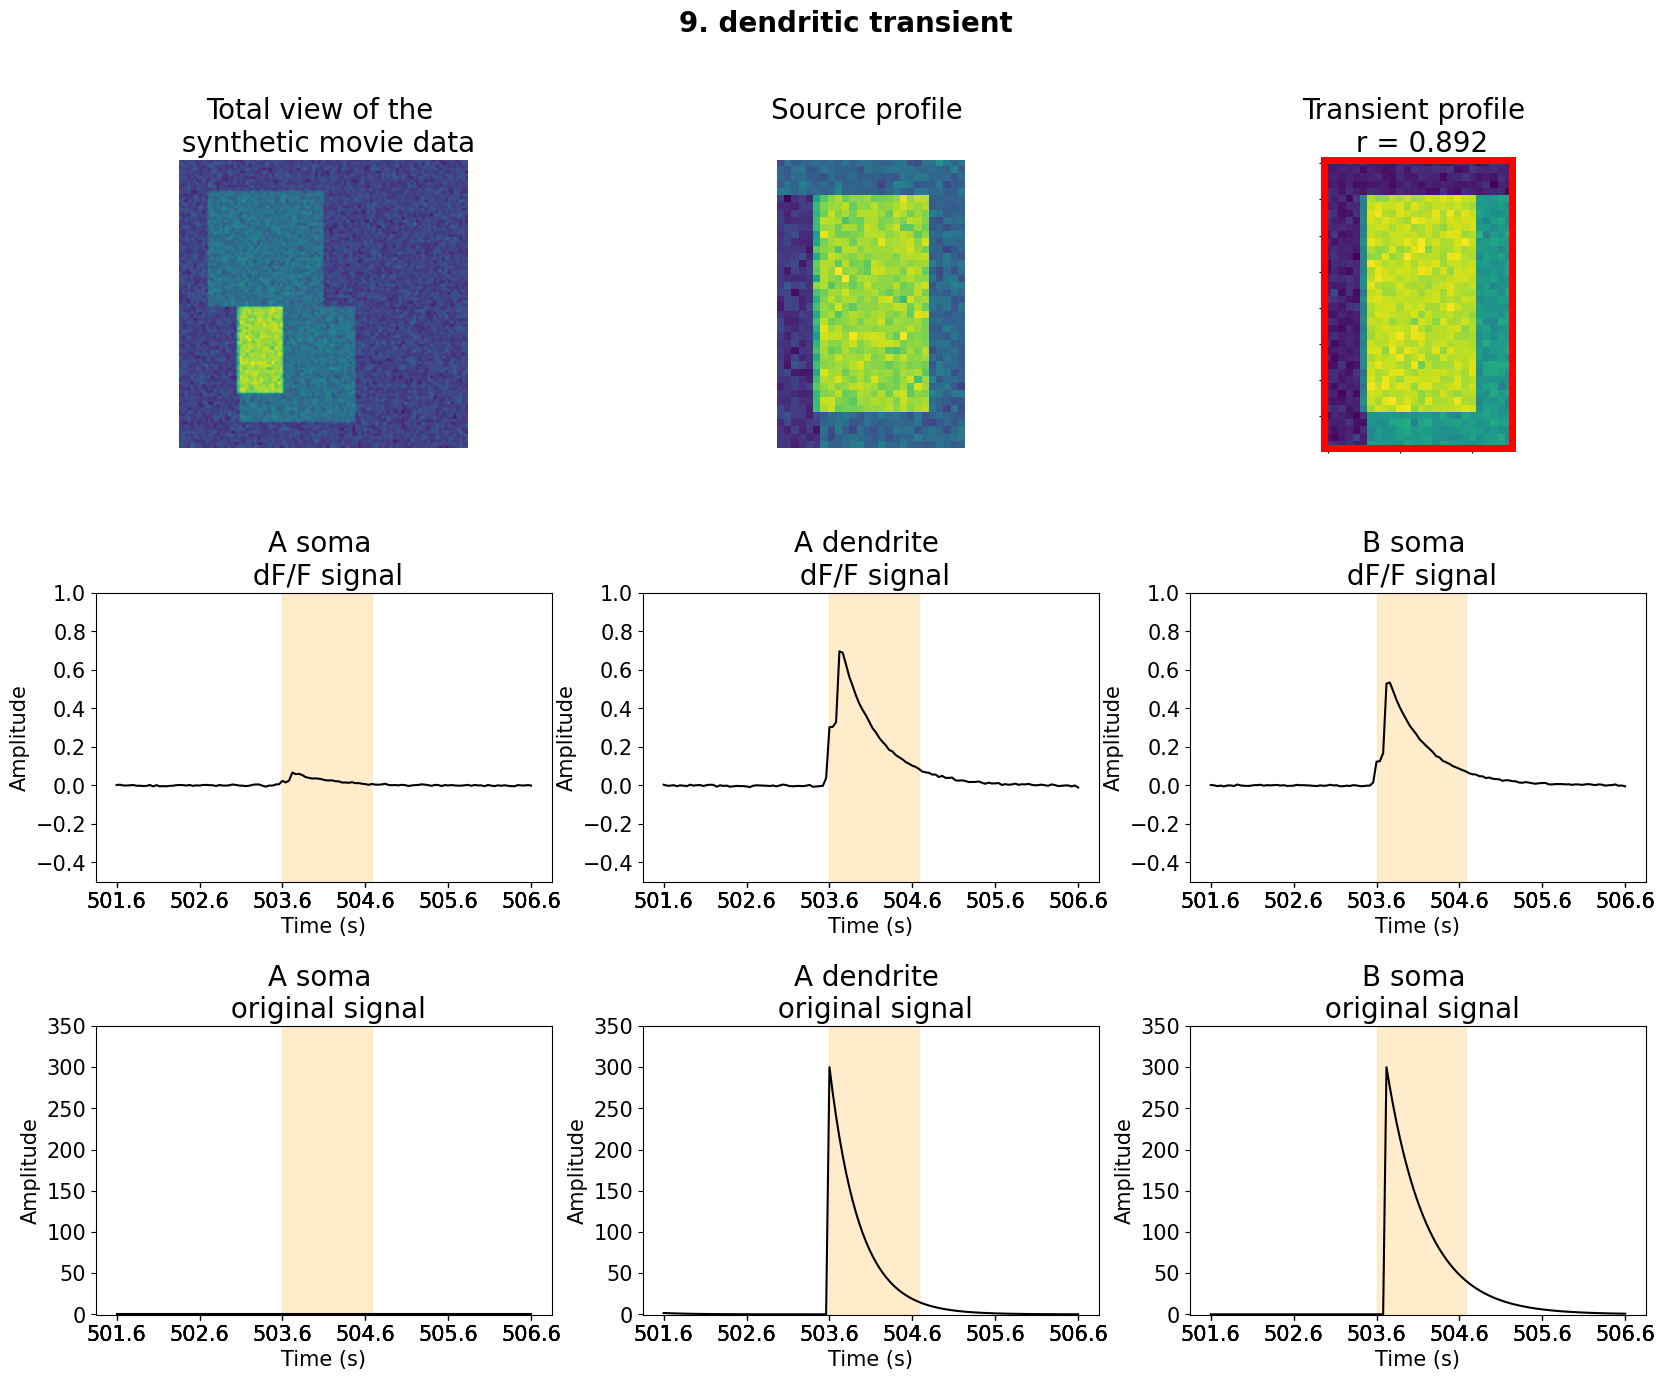

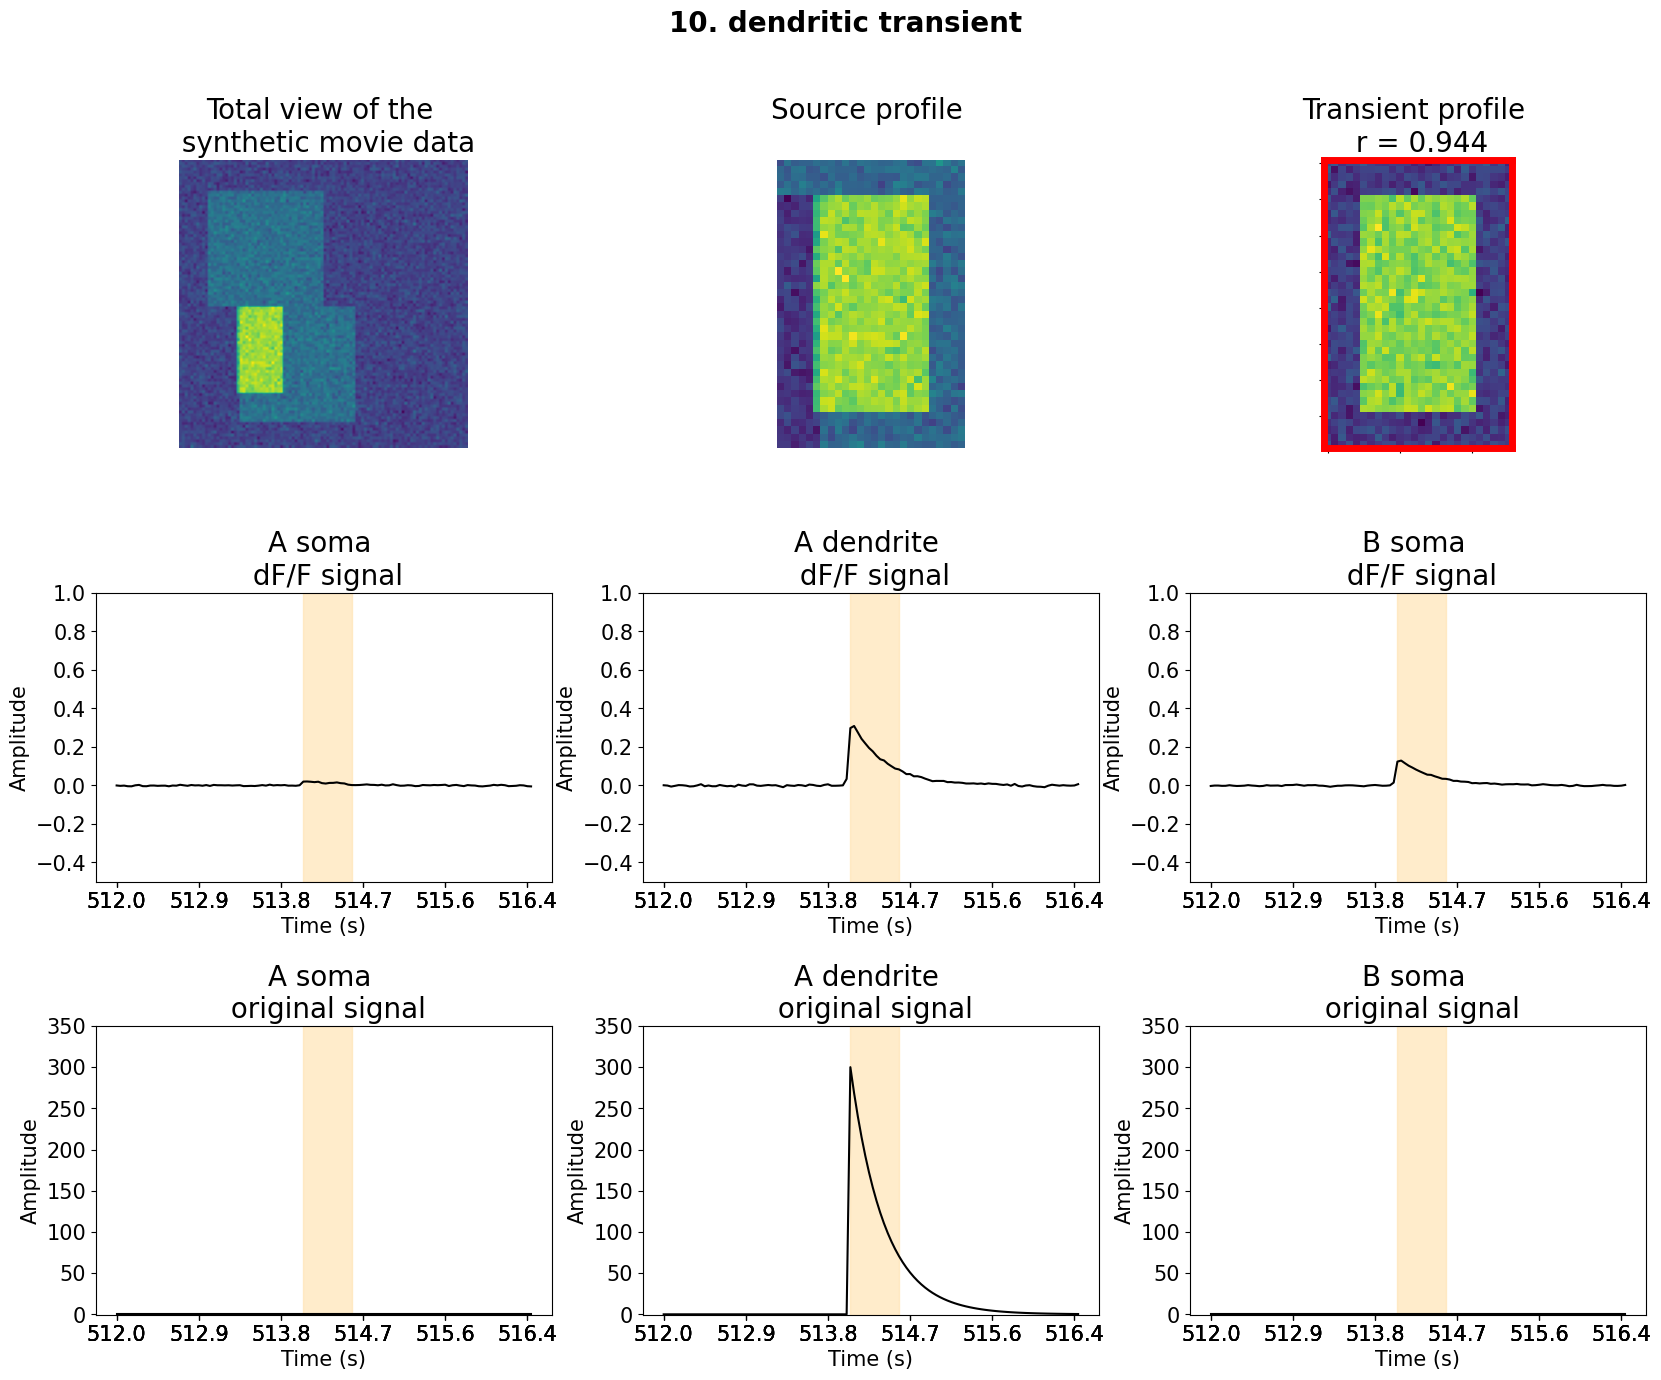

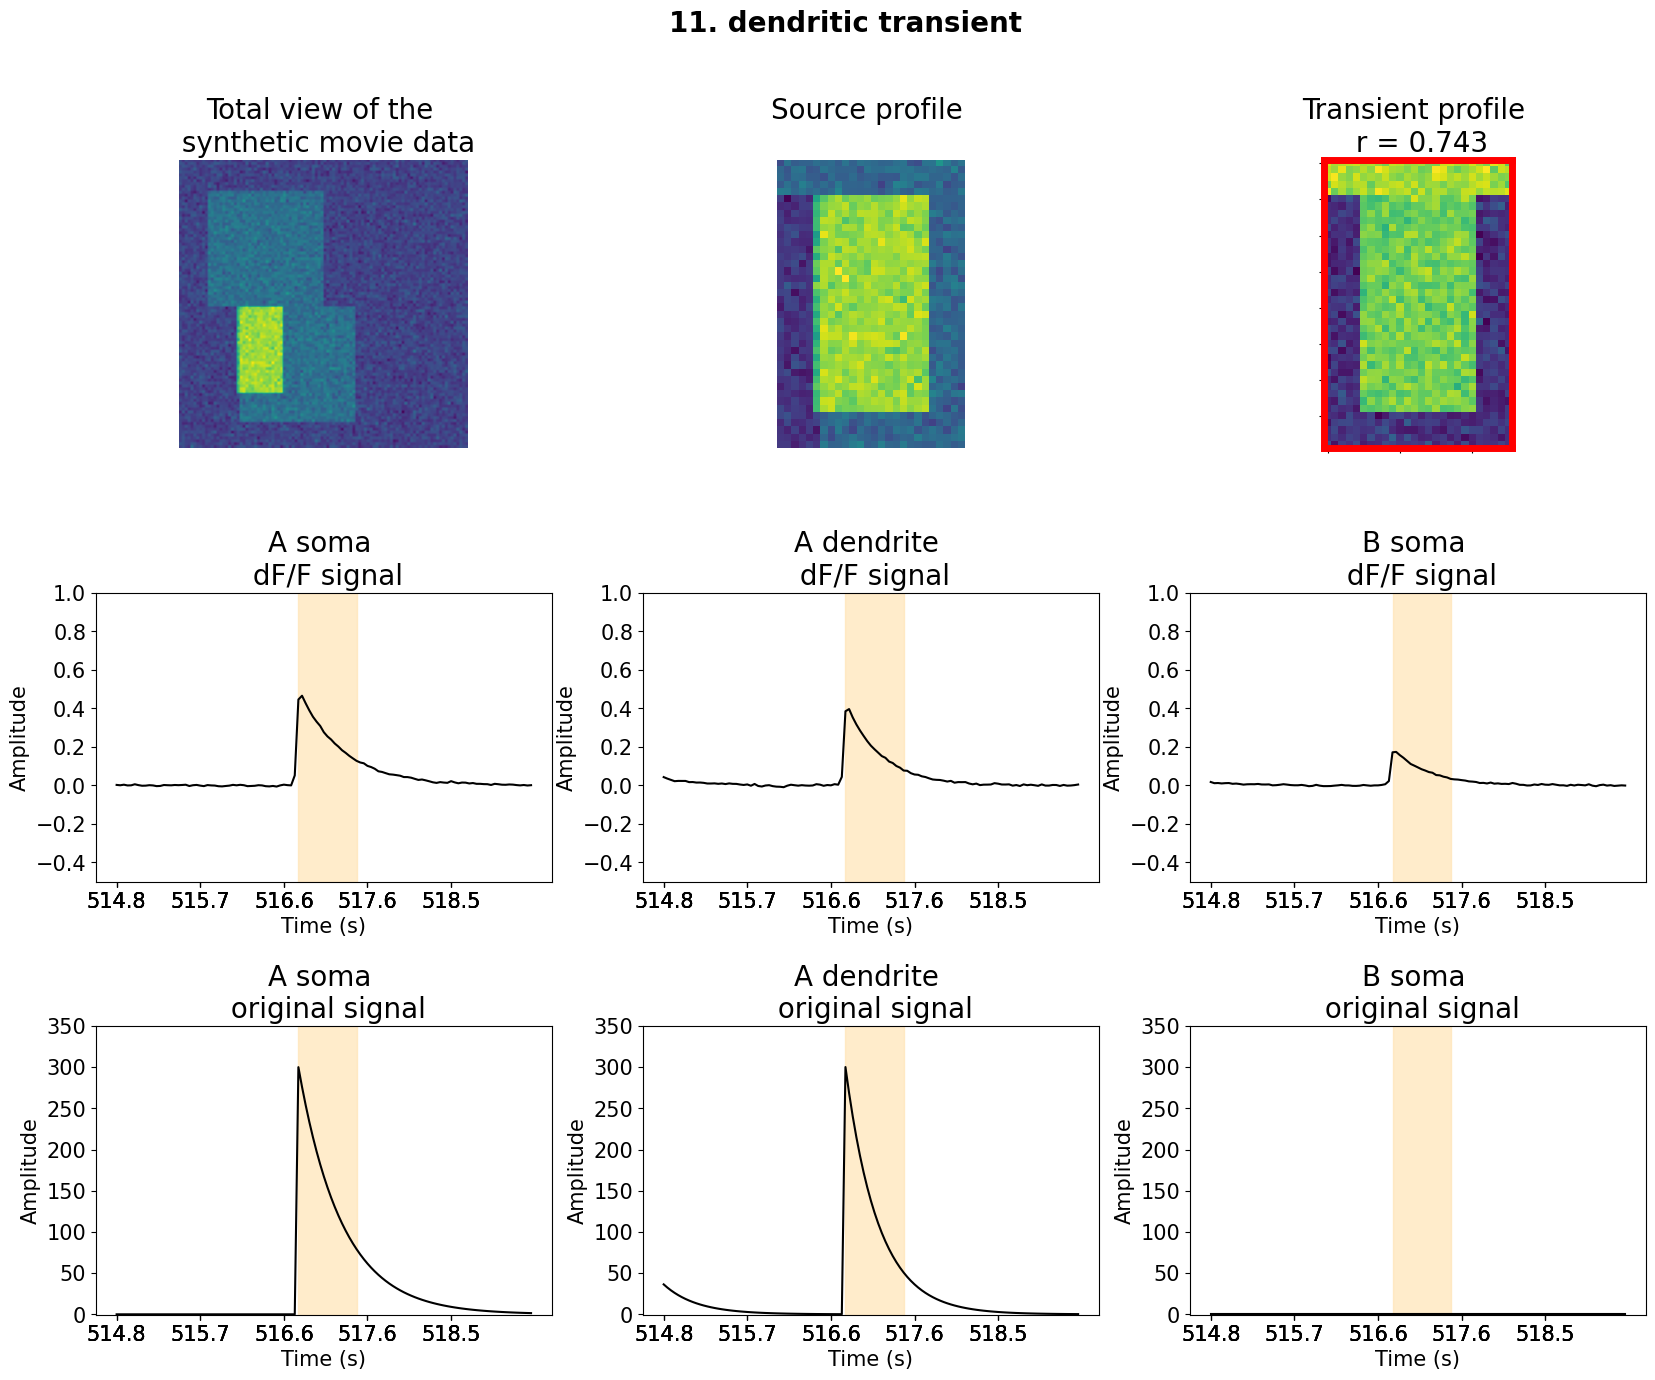

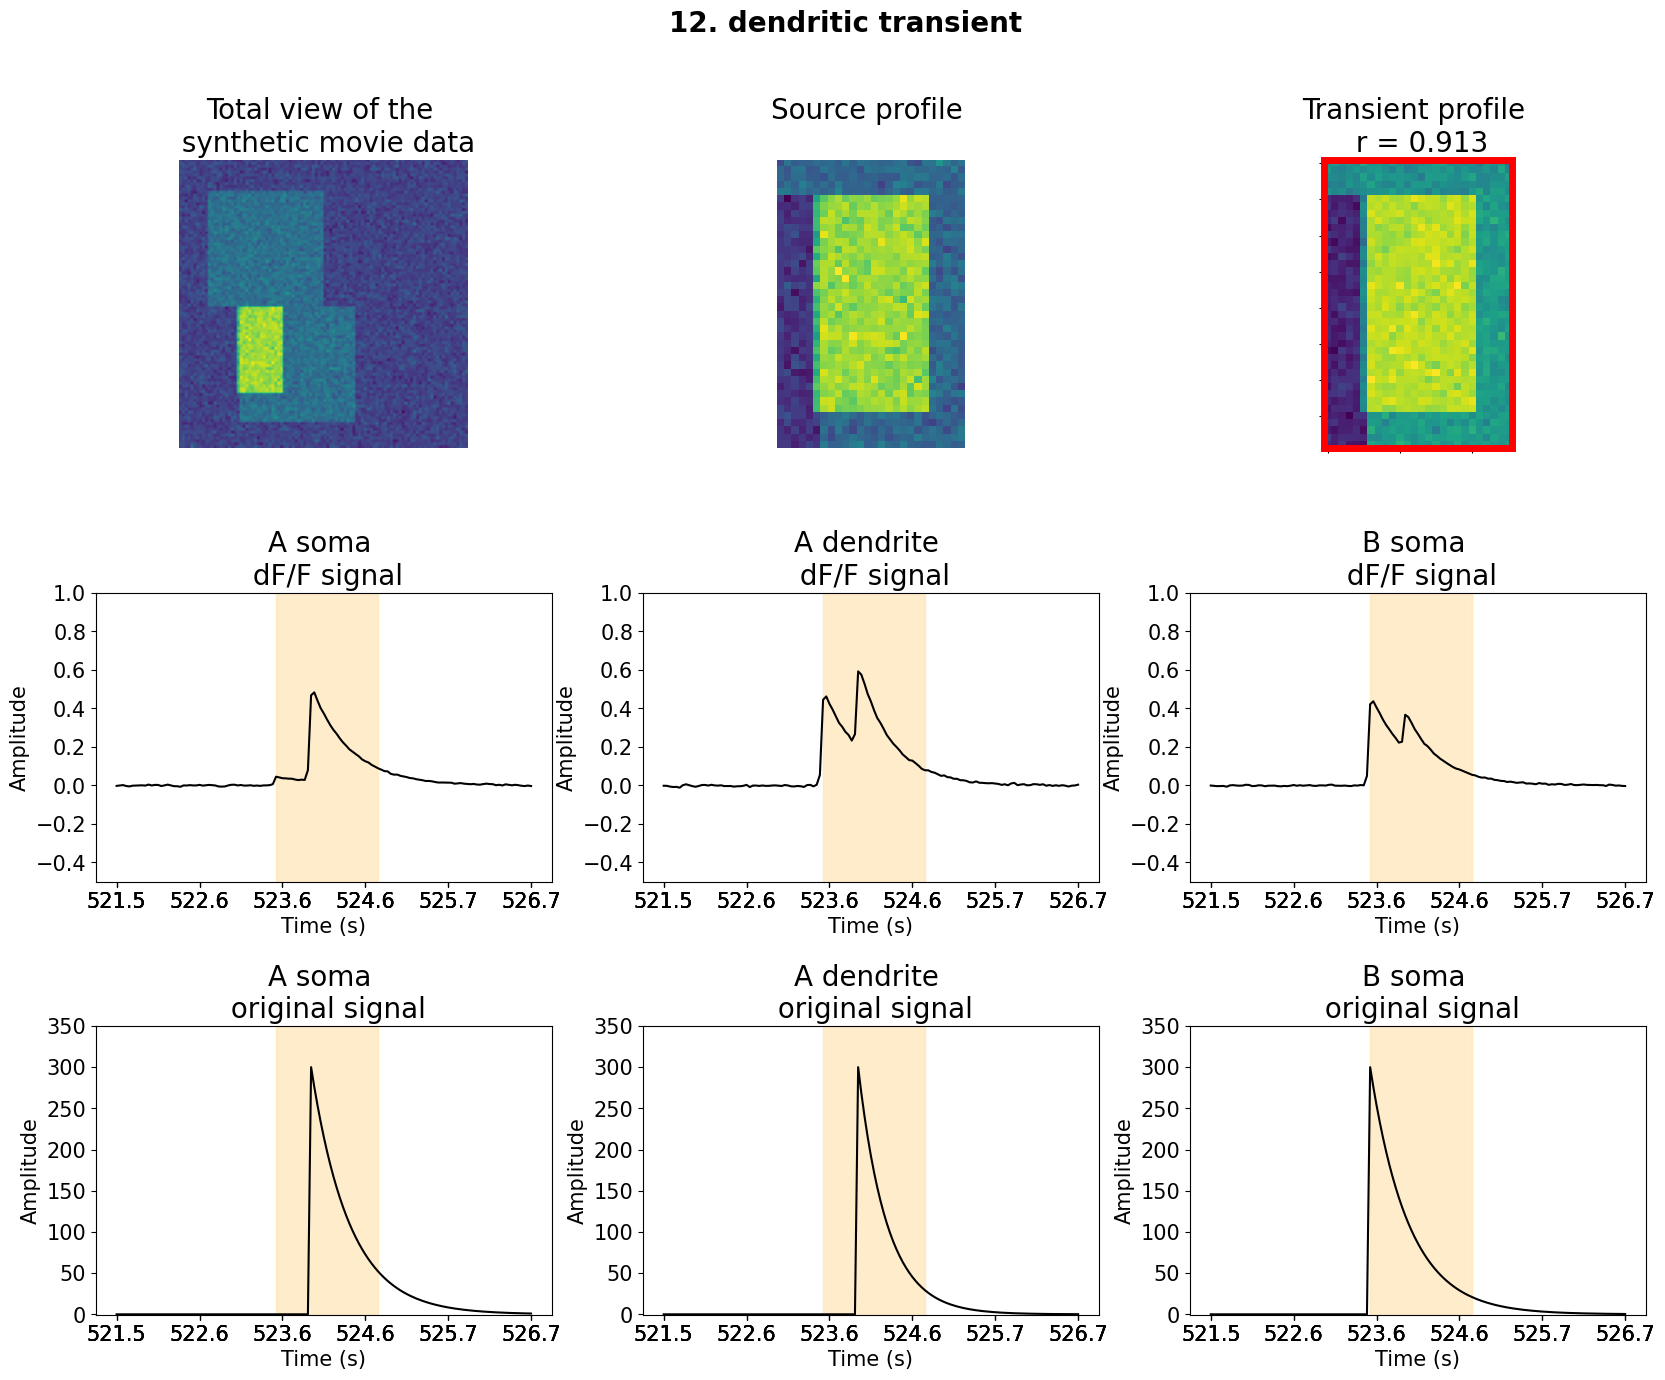

In [21]:
create_spatial_transient_profiles(dF_mean_img, ROI_Asoma, ROI_dendrite, ROI_Bsoma,
                                  dF_a_soma, dF_a_dend, dF_b_soma,
                                  'kullback-leibler', 5000,
                                  0.0011, 0.0017, 0.5,
                                  0.5, 0.1, 0.099,
                                  50, 4, '{0}. dendritic transient', '3. recording sequence, dendritic events - 4. ROI.pdf')